In [1]:
from kaggle_secrets import UserSecretsClient
secret_label = "Token"
token = UserSecretsClient().get_secret(secret_label)

! git clone https://{token}@github.com/CarloSgaravatti/Recsys_Challenge_2023.git

Cloning into 'Recsys_Challenge_2023'...
remote: Enumerating objects: 6665, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 6665 (delta 89), reused 0 (delta 0), pack-reused 6557
Receiving objects: 100% (6665/6665), 2.95 GiB | 23.52 MiB/s, done.
Resolving deltas: 100% (5456/5456), done.
Updating files: 100% (516/516), done.


In [2]:
! pip install PyGithub requests

  Obtaining dependency information for PyGithub from https://files.pythonhosted.org/packages/be/04/810d131be173cba445d3658a45512b2b2b3d0960d52c4a300d6ec5e00f52/PyGithub-2.1.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 14.5 MB/s eta 0:00:00


In [3]:
! pip install implicit

  Obtaining dependency information for implicit from https://files.pythonhosted.org/packages/cd/cc/deac70cae8cc32c9885d0cd73bc66e1b3cbea36ae7080b8c83995eaf5322/implicit-0.7.2-cp310-cp310-manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 37.1 MB/s eta 0:00:00


In [4]:
! cd /kaggle/working/Recsys_Challenge_2023 && python run_compile_all_cython.py

run_compile_all_cython: Found 10 Cython files in 4 folders...
run_compile_all_cython: All files will be compiled using your current python environment: '/opt/conda/bin/python'
Compiling [1/10]: MatrixFactorizationImpressions_Cython_Epoch.pyx... 
In file included from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarraytypes.h:1940,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from MatrixFactorizationImpressions_Cython_Epoch.c:1109:
/opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~
MatrixFactorizationImpressions_Cython_Epoch.c: In functio

In [5]:
import numpy as np
from numpy import linalg as LA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import random
import tqdm
import gc
import time
import os
import shutil
import optuna
import scipy.sparse as sps
import scipy.stats as stats
from concurrent.futures import ThreadPoolExecutor

from lightgbm import LGBMClassifier

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/training-tuned-models/als_all.npz
/kaggle/input/training-tuned-models/__results__.html
/kaggle/input/training-tuned-models/ease_r_all.zip
/kaggle/input/training-tuned-models/mult_vae_2_train_validation.zip
/kaggle/input/training-tuned-models/als_xgboost_train_validation.npz
/kaggle/input/training-tuned-models/als_train_validation.npz
/kaggle/input/training-tuned-models/mult_vae_2_xgboost_train_validation.zip
/kaggle/input/training-tuned-models/slim_recall_train_validation.zip
/kaggle/input/training-tuned-models/ease_r_train_validation.zip
/kaggle/input/training-tuned-models/__notebook__.ipynb
/kaggle/input/training-tuned-models/ials_xgboost_train_validation.zip
/kaggle/input/training-tuned-models/ials_train_validation.zip
/kaggle/input/training-tuned-models/mult_vae_2_all.zip
/kaggle/input/training-tuned-models/ease_r_xgboost_train_validation.zip
/kaggle/input/training-tuned-models/__output__.json
/kaggle/input/training-tuned-models/ials_all.zip
/kaggle/input/training-tun

In [6]:
%cd /kaggle/working/Recsys_Challenge_2023

/kaggle/working/Recsys_Challenge_2023


In [7]:
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Recommenders.SLIM.SLIMElasticNetRecommender import MultiThreadSLIM_SLIMElasticNetRecommender, SLIMElasticNetRecommender
from Evaluation.Evaluator import EvaluatorHoldout
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender, PureSVDItemRecommender, ScaledPureSVDRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Recommenders.KNN.ItemKNNSimilarityHybridRecommender import ItemKNNSimilarityHybridRecommender
from Recommenders.KNN.ItemKNNCustomSimilarityRecommender import ItemKNNCustomSimilarityRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.BaseRecommender import BaseRecommender
from Recommenders.EASE_R.EASE_R_Recommender import EASE_R_Recommender
from Recommenders.Neural.MultVAERecommender import MultVAERecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.SLIM.SLIM_BPR_Python import SLIM_BPR_Python
from Recommenders.MatrixFactorization.NMFRecommender import NMFRecommender
from Recommenders.Neural.MultVAERecommender import MultVAERecommender

from Recommenders.Hybrid.LinearCombinationRecommender import LinearCombinationRecommender
from Data_manager.CrossValidationSplitter import CrossValidationSplitter
from Recommenders.MatrixFactorization.ALSImplicitRecommender import ALSImplicitRecommender
from Recommenders.GraphBased.HHPRecommender import HHPRecommender
from Recommenders.GraphBased.TwoWayRankAggregationRecommender import TwoWayRankAggregationRecommender

np.int = int
np.random.seed(42)
np.bool = bool
np.float = float

In [8]:
from github import Github
from github import Auth

auth = Auth.Token(token)
g = Github(auth=auth)

repo = None
for r in g.get_user().get_repos():
    if r.name == 'Recsys_Challenge_2023':
        repo = r
        print('Repository found')

Repository found


In [9]:
def upload_file(filepath_kaggle, filepath_github, commit_message):
    try:
        contents = repo.get_contents(filepath_github)
        with open(filepath_kaggle, "rb") as file:
            repo.update_file(contents.path, commit_message, file.read(), contents.sha)
    except Exception:
        with open(filepath_kaggle, "rb") as file:
            repo.create_file(filepath_github, commit_message, file.read())

In [10]:
config = {
    'tune_parameters': True,
    'n_trials': 35,
    'database_path': '/kaggle/working/tuning_hybrid_xgboost.db',
    'copy_prev_tuning_db': True,
    'copy_prev_best_params': True,
    'save_github': True
}

In [11]:
train_data = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_train.csv')
user_ids_test = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_target_users_test.csv')

In [12]:
URM_all = sps.csr_matrix((train_data.data.values,
                          ((train_data.row - 1).values, (train_data.col - 1).values)),
                        shape=(train_data.row.max(), train_data.col.max()))
URM_all

<13024x22347 sparse matrix of type '<class 'numpy.float64'>'
	with 478730 stored elements in Compressed Sparse Row format>

In [13]:
URM_train_complete, URM_test_complete = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.8)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train_complete, train_percentage = 0.8)

In [14]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_knn_item.json', 'r') as params_file:
    params_item_knn = json.load(params_file)
params_item_knn

{'topK': 14,
 'shrink': 25,
 'similarity': 'tversky',
 'tversky_alpha': 0.18163095712123836,
 'tversky_beta': 1.8529812241698465}

In [15]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_RP3.json', 'r') as params_file:
    params_rp3 = json.load(params_file)
params_rp3

{'alpha': 0.3408516511081212, 'beta': 0.1447198697205665, 'topK': 32}

In [16]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_knn_user.json', 'r') as params_file:
    params_user_knn = json.load(params_file)
params_user_knn

{'topK': 498,
 'shrink': 0,
 'similarity': 'asymmetric',
 'asymmetric_alpha': 0.39792525383867455}

In [17]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_alpha.json', 'r') as params_file:
    params_p3alpha = json.load(params_file)
params_p3alpha

{'normalize_similarity': 'True',
 'implicit': 'True',
 'alpha': 0.29354071531607107,
 'topK': 49}

In [18]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_hybrid_merging.json', 'r') as params_file:
    params_merging = json.load(params_file)
params_merging

{'alpha': 0.3375591188839621, 'topK': 86}

In [19]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_hybrid_lr_comb_rp3_p3a_item.json', 'r') as params_file:
    params_lr_comb = json.load(params_file)
params_lr_comb

{'w1': 0.6982294749234325, 'w2': 0.9336649353144076, 'w3': 0.8685182329823133}

In [20]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/pure_svd_params.json', 'r') as params_file:
    params_pure_svd = json.load(params_file)
params_pure_svd

{'factors': 30}

In [21]:
# with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_puresvd_item.json', 'r') as params_file:
#     params_pure_svd_item = json.load(params_file)
params_pure_svd_item = {"topK": 43, "num_factors": 171}

In [22]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_puresvd_scaled.json', 'r') as params_file:
    params_scaled = json.load(params_file)
params_scaled

{'num_factors': 179,
 'scaling_items': 5.3298425368534826e-05,
 'scaling_users': 0.2791990262721904}

In [23]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_hhp.json', 'r') as params_file:
    params_hhp = json.load(params_file)
params_hhp

{'hybrid_lambda': 0.8450256587797654, 'topK': 61}

In [24]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_twra.json', 'r') as params_file:
    params = json.load(params_file)

params_twra = {
    'base_f_algorithm': params['base_f_algorithm'], 
    'base_b_algorithm': params['base_b_algorithm'], 
    'convex_lambda': params['convex_lambda'],
}

if params['base_f_algorithm'] == 'p3':
    params_twra['f_params'] = {
        'topK': params['f_p3_topK'],
        'implicit': True, 
        'normalize_similarity': True
    }
elif params['base_f_algorithm'] == 'p3alpha':
    params_twra['f_params'] = {
        'alpha': params['f_p3a_alpha'],
        'topK': params['f_p3a_topK'],
        'implicit': True, 
        'normalize_similarity': True
    }
elif params['base_f_algorithm'] == 'rp3beta':
    params_twra['f_params'] = {
        'alpha': params['f_rp3_alpha'],
        'beta': params['f_rp3_beta'],
        'topK': params['f_rp3_topK'],
        'implicit': True, 
        'normalize_similarity': True
    }
else:
    params_twra['f_params'] = {
        'hybrid_lambda': params['f_hhp_hybrid_lambda'],
        'topK': params['f_hhp_topK'],
    }

if params['base_b_algorithm'] == 'p3':
    params_twra['b_params'] = {
        'topK': params['b_p3_topK'],
        'implicit': True, 
        'normalize_similarity': True
    }
elif params['base_b_algorithm'] == 'p3alpha':
    params_twra['b_params'] = {
        'alpha': params['b_p3a_alpha'],
        'topK': params['b_p3a_topK'],
        'implicit': True, 
        'normalize_similarity': True
    }
elif params['base_b_algorithm'] == 'rp3beta':
    params_twra['b_params'] = {
        'alpha': params['b_rp3_alpha'],
        'beta': params['b_rp3_beta'],
        'topK': params['b_rp3_topK'],
        'implicit': True, 
        'normalize_similarity': True
    }
else:
    params_twra['b_params'] = {
        'hybrid_lambda': params['b_hhp_hybrid_lambda'],
        'topK': params['b_hhp_topK'],
    }

In [25]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_rp3_recall@50.json', 'r') as params_file:
    params_rp3_recall = json.load(params_file)
params_rp3_recall

{'alpha': 0.2139985499567939, 'beta': 0.2194371742883361, 'topK': 154}

In [26]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_item_knn_recall@50.json', 'r') as params_file:
    params_item_knn_recall = json.load(params_file)
params_item_knn_recall

{'topK': 62,
 'shrink': 480,
 'similarity': 'tversky',
 'feature_weighting': 'BM25',
 'tversky_alpha': 0.03679620043176055,
 'tversky_beta': 1.9314395554791928}

In [27]:
shutil.copyfile(
    '/kaggle/input/training-tuned-models/ials_xgboost_train_validation.zip', 
    '/kaggle/working/ials_xgboost_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/ials_train_validation.zip', 
    '/kaggle/working/ials_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/ials_all.zip', 
    '/kaggle/working/ials_all.zip', 
)

shutil.copyfile(
    '/kaggle/input/training-tuned-models/als_xgboost_train_validation.npz', 
    '/kaggle/working/als_xgboost_train_validation.npz', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/als_train_validation.npz', 
    '/kaggle/working/als_train_validation.npz', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/als_all.npz', 
    '/kaggle/working/als_all.npz', 
)

shutil.copyfile(
    '/kaggle/input/training-tuned-models/slim_recall_xgboost_train_validation.zip', 
    '/kaggle/working/slim_recall_xgboost_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/slim_recall_train_validation.zip', 
    '/kaggle/working/slim_recall_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/slim_recall_all.zip', 
    '/kaggle/working/slim_recall_all.zip', 
)

shutil.copyfile(
    '/kaggle/input/training-tuned-models/mult_vae_2_xgboost_train_validation.zip', 
    '/kaggle/working/mult_vae_2_xgboost_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/mult_vae_2_train_validation.zip', 
    '/kaggle/working/mult_vae_2_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/mult_vae_2_all.zip', 
    '/kaggle/working/mult_vae_2_all.zip', 
)

'/kaggle/working/mult_vae_2_all.zip'

In [28]:
recommender_item = ItemKNNCFRecommender(URM_train)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_train)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_train)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_train)
recommender_p3a.fit(**params_p3alpha)

recommender_pure_svd = PureSVDRecommender(URM_train)
recommender_pure_svd.fit(num_factors=params_pure_svd['factors'])
user_factors_train = recommender_pure_svd.USER_factors
item_factors_train = recommender_pure_svd.ITEM_factors

recommender_scaled_svd = ScaledPureSVDRecommender(URM_train)
recommender_scaled_svd.fit(**params_scaled)

recommender_pure_svd_item = PureSVDItemRecommender(URM_train)
recommender_pure_svd_item.fit(**params_pure_svd_item)

recommender_nmf = NMFRecommender(URM_train)
recommender_nmf.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'nmf_xgboost_train_validation.zip')

recommender_slim_bpr = SLIM_BPR_Python(URM_train)
recommender_slim_bpr.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_bpr_xgboost_train_validation.zip')

recommender_slim = SLIMElasticNetRecommender(URM_train)
recommender_slim.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_elastic_xgboost_train_validation.zip')

recommender_ease_r = EASE_R_Recommender(URM_train)
recommender_ease_r.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'ease_r_xgboost_train_validation.zip')

recommender_ials = IALSRecommender(URM_train)
recommender_ials.load_model('/kaggle/working/', 'ials_xgboost_train_validation.zip')

recommender_vae = MultVAERecommender(URM_train)
recommender_vae.load_model('/kaggle/working/', 'mult_vae_2_xgboost_train_validation')

recommender_hhp = HHPRecommender(URM_train)
recommender_hhp.fit(**params_hhp)

recommender_twra = TwoWayRankAggregationRecommender(URM_train)
recommender_twra.fit(**params_twra)

# recommender_als = ALSImplicitRecommender(URM_train)
# recommender_als.load_model('/kaggle/working/', 'als_xgboost_train_validation.npz')

########################## CANDIDATE GENERATORS ##########################

recommender_slim_recall = SLIMElasticNetRecommender(URM_train)
recommender_slim_recall.load_model('/kaggle/working/', 'slim_recall_xgboost_train_validation.zip')

recommender_rp3_recall = RP3betaRecommender(URM_train)
recommender_rp3_recall.fit(**params_rp3_recall)

recommender_item_recall = ItemKNNCFRecommender(URM_train)
recommender_item_recall.fit(**params_item_knn_recall)

ItemKNNCFRecommender: URM Detected 851 ( 6.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 476 ( 2.1%) items with no interactions.
Similarity column 22347 (100.0%), 4934.87 column/sec. Elapsed time 4.53 sec
UserKNNCFRecommender: URM Detected 851 ( 6.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 476 ( 2.1%) items with no interactions.
Similarity column 13024 (100.0%), 5184.48 column/sec. Elapsed time 2.51 sec
RP3betaRecommender: URM Detected 851 ( 6.5%) users with no interactions.
RP3betaRecommender: URM Detected 476 ( 2.1%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 2677.67 column/sec. Elapsed time 8.35 sec
P3alphaRecommender: URM Detected 851 ( 6.5%) users with no interactions.
P3alphaRecommender: URM Detected 476 ( 2.1%) items with no interactions.
P3alphaRecommender: Similarity column 22347 (100.0%), 3272.07 column/sec. Elapsed time 6.83 sec
PureSVDRecommender: URM Detected 851 ( 6.5%) users with no inter

In [29]:
evaluator = EvaluatorHoldout(URM_test_complete, cutoff_list=[10])

EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions


In [30]:
cutoff = 50
n_users, n_items = URM_train.shape

training_dataframe = pd.DataFrame(index=range(0, n_users), columns = ["ItemID"])
training_dataframe.index.name='UserID'

for user_id in tqdm.tqdm_notebook(range(n_users)):    
    recommendations_slim = recommender_slim_recall.recommend(user_id, cutoff = cutoff)
    recommendations_knn = recommender_item_recall.recommend(user_id, cutoff = cutoff)
    recommendations_rp3 = recommender_rp3_recall.recommend(user_id, cutoff = cutoff)
    recommendations = np.union1d(recommendations_slim, np.union1d(recommendations_knn, recommendations_rp3))
    if user_id == 0:
        print(recommendations)
    training_dataframe.loc[user_id, "ItemID"] = recommendations
    
training_dataframe = training_dataframe.explode("ItemID")
training_dataframe

/tmp/ipykernel_18/2461008040.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for user_id in tqdm.tqdm_notebook(range(n_users)):


  0%|          | 0/13024 [00:00<?, ?it/s]

[   0    1    2    3    9   28   35   53   57   75   76   84   86   97
  100  101  111  122  136  138  155  170  215  253  256  260  283  288
  336  341  366  402  428  429  505  514  533  591  617  634  636  693
  715  772  849  868  921  976 1056 1067 1082 1088 1131 1213 1222 1287
 1337 1421 1480 1489 1515 1545 1629 1744 1934 2002 2011 2498 2667 2781
 3156 3315 3728 6222 8455 8500]


,ItemID
UserID,
0,0
0,1
0,2
0,3
0,9
...,...
13023,11653
13023,11827
13023,11955


In [31]:
URM_validation_coo = sps.coo_matrix(URM_validation)

correct_recommendations = pd.DataFrame({"UserID": URM_validation_coo.row,
                                        "ItemID": URM_validation_coo.col})
correct_recommendations

,UserID,ItemID
0,0,15
1,0,385
2,0,1934
3,0,4302
4,0,17444
...,...,...
76592,13023,2365
76593,13023,2961
76594,13023,3606
76595,13023,6282


In [32]:
training_dataframe = pd.merge(training_dataframe, correct_recommendations, on=['UserID','ItemID'], how='left', indicator='Exist')
training_dataframe["Label"] = training_dataframe["Exist"] == "both"
training_dataframe.drop(columns = ['Exist'], inplace=True)
training_dataframe

,UserID,ItemID,Label
0,0,0,False
1,0,1,False
2,0,2,False
3,0,3,False
4,0,9,False
...,...,...,...
1067012,13023,11653,False
1067013,13023,11827,False
1067014,13023,11955,False
1067015,13023,13592,False


In [33]:
training_dataframe.Label.sum()

19954

In [34]:
recommender_object_dict = {
    'ItemKNN': recommender_item,
    'UserKNN': recommender_user,
    'P3Alpha': recommender_p3a,
    'RP3Beta': recommender_rp3,
    'NMF': recommender_nmf,
    'PureSVD': recommender_pure_svd,
    'ScaledSVD': recommender_scaled_svd,
    'ItemPureSVD': recommender_pure_svd_item,
    'SlimElastic': recommender_slim,
    'SlimBPR': recommender_slim_bpr,
    'EaseR': recommender_ease_r,
    'IALS': recommender_ials,
    'MultVAE': recommender_vae,
    'HHP': recommender_hhp,
    'TWRA': recommender_twra,
    # 'ALS': recommender_als
}

In [35]:
training_dataframe = training_dataframe.set_index('UserID')

for label, recommender in tqdm.auto.tqdm(recommender_object_dict.items()):
    scores = recommender._compute_item_score(np.arange(n_users))
    linf_scores = scores / (LA.norm(scores, np.inf, axis=1, keepdims=True) + 1e-6)
    
    for user_id in tqdm.auto.tqdm(range(n_users)):
        item_list = training_dataframe.loc[user_id, "ItemID"].values.tolist()
        linf_scores[user_id, :] = recommender._remove_seen_on_scores(user_id, linf_scores[user_id, :])
        training_dataframe.loc[user_id, f"{label}_Score"] = linf_scores[user_id, item_list]
        
        rank = np.argsort(linf_scores[user_id, :])[::-1]
        positions = np.zeros(n_items, dtype=int)
        positions[rank] = np.arange(n_items)
        training_dataframe.loc[user_id, f"{label}_RankPosition"] = positions[item_list]
        
        recommended = np.isin(item_list, rank[:10], assume_unique=True)
        training_dataframe.loc[user_id, f"{label}_Recommended"] = recommended.astype(int)
    
    del scores, linf_scores, rank, positions, recommended
    gc.collect()

item_item_S = recommender_item.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        training_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = 0
        training_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = 0
        training_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = 0
        training_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = 0
        training_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = 0
        training_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = 0
    else:
        similarities = item_item_S[training_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        training_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = similarities.mean(axis=1).flatten()
        training_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = similarities.max(axis=1).flatten()
        training_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = similarities.min(axis=1).flatten()
        training_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = similarities.std(axis=1).flatten()
        training_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = stats.skew(similarities, axis=1)
        training_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

item_item_S = recommender_rp3.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        training_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = 0
        training_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = 0
        training_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = 0
        training_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = 0
        training_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = 0
        training_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = 0
    else:
        similarities = item_item_S[training_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        training_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = similarities.mean(axis=1).flatten()
        training_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = similarities.max(axis=1).flatten()
        training_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = similarities.min(axis=1).flatten()
        training_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = similarities.std(axis=1).flatten()
        training_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = stats.skew(similarities, axis=1)
        training_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

# todo: cluster if possible the similarity matrix of KNN or RP3, then add for each users some features 
# that represent something like users that like only items from the same cluster (e.g. items variability)
# same can be done with users and items reversed (i.e. using User KNN)

recommended_columns = [col for col in training_dataframe.columns if col.endswith('_Recommended')]
training_dataframe['Counter_Recommended'] = training_dataframe[recommended_columns].sum(axis=1).astype(int)

position_columns = [col for col in training_dataframe.columns if col.endswith('_RankPosition')]
training_dataframe['Mean_RankPosition'] = training_dataframe[position_columns].mean(axis=1)
training_dataframe['Std_RankPosition'] = training_dataframe[position_columns].std(axis=1)
training_dataframe['Skew_RankPosition'] = training_dataframe[position_columns].skew(axis=1)
training_dataframe['Kurtosis_RankPosition'] = training_dataframe[position_columns].kurtosis(axis=1)

# todo: weighted score makes sense? Same features of position but for score might be not useful
# since ranges are different

training_dataframe = training_dataframe.reset_index()
training_dataframe = training_dataframe.rename(columns = {"index": "UserID"})
training_dataframe

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

/tmp/ipykernel_18/2167912425.py:39: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  training_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = stats.skew(similarities, axis=1)
/tmp/ipykernel_18/2167912425.py:40: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  training_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = stats.kurtosis(similarities, axis=1)


  0%|          | 0/13024 [00:00<?, ?it/s]

,UserID,ItemID,Label,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,...,MaxSimilarityToSeenRP3,MinSimilarityToSeenRP3,StdSimilarityToSeenRP3,SkewSimilarityToSeenRP3,KurtosisSimilarityToSeenRP3,Counter_Recommended,Mean_RankPosition,Std_RankPosition,Skew_RankPosition,Kurtosis_RankPosition
0,0,0,False,0.000000,21981.0,0.0,0.002247,239.0,0.0,0.172726,...,0.000000,0.0,0.000000,NaN,NaN,0,4445.666667,8529.421205,1.690904,1.091150
1,0,1,False,0.000000,7492.0,0.0,0.002246,240.0,0.0,0.000000,...,0.000000,0.0,0.000000,NaN,NaN,0,4343.000000,4470.049600,0.489168,-1.226420
2,0,2,False,0.000000,7493.0,0.0,0.005024,181.0,0.0,0.000000,...,0.000000,0.0,0.000000,NaN,NaN,1,5105.333333,6395.478421,1.250119,1.349319
3,0,3,False,0.000000,7494.0,0.0,0.003501,190.0,0.0,0.000000,...,0.000000,0.0,0.000000,NaN,NaN,0,3841.733333,4173.833344,0.298786,-1.885747
4,0,9,False,0.000000,7499.0,0.0,0.004615,183.0,0.0,0.000000,...,0.000000,0.0,0.000000,NaN,NaN,0,3788.000000,4224.468792,0.373077,-1.696020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1067012,13023,11653,False,0.176484,17.0,0.0,0.124148,146.0,0.0,0.176945,...,0.065990,0.0,0.011571,4.329403,18.561111,0,116.933333,114.431805,0.992899,-0.336770
1067013,13023,11827,False,0.039908,156.0,0.0,0.102497,217.0,0.0,0.000000,...,0.024023,0.0,0.003503,6.559135,41.022263,0,4422.266667,7480.642309,1.583376,0.719424
1067014,13023,11955,False,0.092565,54.0,0.0,0.111171,184.0,0.0,0.077925,...,0.040833,0.0,0.008920,3.700808,12.059912,0,421.600000,570.533309,2.327301,5.760052
1067015,13023,13592,False,0.295934,5.0,1.0,0.102905,214.0,0.0,0.233513,...,0.080118,0.0,0.016885,2.835449,7.682983,5,283.400000,365.269138,1.096526,-0.394693


In [36]:
item_popularity = np.ediff1d(sps.csc_matrix(URM_train).indptr)
item_popularity = item_popularity / np.max(item_popularity)
training_dataframe['item_popularity'] = item_popularity[training_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(URM_train).indptr)
user_popularity = user_popularity / np.max(user_popularity)
training_dataframe['user_profile_len'] = user_popularity[training_dataframe["UserID"].values.astype(int)]

mainstream_user = URM_train.dot(item_popularity) / np.where(user_popularity == 0, 1, user_popularity)
training_dataframe['mainstream_user'] = mainstream_user[training_dataframe["UserID"].values.astype(int)]

mainstream_item = URM_train.T.dot(user_popularity) / np.where(item_popularity == 0, 1, item_popularity)
training_dataframe['mainstream_item'] = mainstream_item[training_dataframe["ItemID"].values.astype(int)]
training_dataframe

,UserID,ItemID,Label,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,...,KurtosisSimilarityToSeenRP3,Counter_Recommended,Mean_RankPosition,Std_RankPosition,Skew_RankPosition,Kurtosis_RankPosition,item_popularity,user_profile_len,mainstream_user,mainstream_item
0,0,0,False,0.000000,21981.0,0.0,0.002247,239.0,0.0,0.172726,...,NaN,0,4445.666667,8529.421205,1.690904,1.091150,0.886424,0.033573,77.384713,64.370937
1,0,1,False,0.000000,7492.0,0.0,0.002246,240.0,0.0,0.000000,...,NaN,0,4343.000000,4470.049600,0.489168,-1.226420,1.000000,0.033573,77.384713,62.304556
2,0,2,False,0.000000,7493.0,0.0,0.005024,181.0,0.0,0.000000,...,NaN,1,5105.333333,6395.478421,1.250119,1.349319,0.816327,0.033573,77.384713,66.387950
3,0,3,False,0.000000,7494.0,0.0,0.003501,190.0,0.0,0.000000,...,NaN,0,3841.733333,4173.833344,0.298786,-1.885747,0.988465,0.033573,77.384713,68.811732
4,0,9,False,0.000000,7499.0,0.0,0.004615,183.0,0.0,0.000000,...,NaN,0,3788.000000,4224.468792,0.373077,-1.696020,0.507542,0.033573,77.384713,58.666614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1067012,13023,11653,False,0.176484,17.0,0.0,0.124148,146.0,0.0,0.176945,...,18.561111,0,116.933333,114.431805,0.992899,-0.336770,0.007986,0.055156,53.265190,302.245004
1067013,13023,11827,False,0.039908,156.0,0.0,0.102497,217.0,0.0,0.000000,...,41.022263,0,4422.266667,7480.642309,1.583376,0.719424,0.006211,0.055156,53.265190,326.633094
1067014,13023,11955,False,0.092565,54.0,0.0,0.111171,184.0,0.0,0.077925,...,12.059912,0,421.600000,570.533309,2.327301,5.760052,0.005324,0.055156,53.265190,211.481415
1067015,13023,13592,False,0.295934,5.0,1.0,0.102905,214.0,0.0,0.233513,...,7.682983,5,283.400000,365.269138,1.096526,-0.394693,0.004437,0.055156,53.265190,296.209113


In [37]:
user_factors_df = pd.DataFrame(user_factors_train[:, :5], columns=[f'user_factor_{i}' for i in range(user_factors_train[:, :5].shape[1])])
item_factors_df = pd.DataFrame(item_factors_train[:, :5], columns=[f'item_factor_{i}' for i in range(item_factors_train[:, :5].shape[1])])

training_dataframe = training_dataframe.merge(item_factors_df, left_on='ItemID', right_index=True)
training_dataframe = training_dataframe.merge(user_factors_df, left_on='UserID', right_index=True)
training_dataframe = training_dataframe.sort_values(by='UserID')
training_dataframe

,UserID,ItemID,Label,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,...,item_factor_0,item_factor_1,item_factor_2,item_factor_3,item_factor_4,user_factor_0,user_factor_1,user_factor_2,user_factor_3,user_factor_4
0,0,0,False,0.000000,21981.0,0.0,0.002247,239.0,0.0,0.172726,...,0.163921,0.090707,-0.216788,-0.041741,0.056197,0.005684,-0.001896,0.008995,-0.013853,-0.002147
54,0,1222,False,0.000000,7796.0,0.0,0.000932,503.0,0.0,0.000000,...,0.008628,0.004001,0.018486,-0.012392,0.001480,0.005684,-0.001896,0.008995,-0.013853,-0.002147
53,0,1213,False,0.215692,16.0,0.0,0.069173,45.0,0.0,0.119938,...,0.007796,-0.009614,0.002953,-0.000483,-0.004862,0.005684,-0.001896,0.008995,-0.013853,-0.002147
52,0,1131,False,0.170961,21.0,0.0,0.000908,520.0,0.0,0.079453,...,0.008328,-0.008771,0.024645,0.012543,0.037796,0.005684,-0.001896,0.008995,-0.013853,-0.002147
51,0,1088,False,0.211910,17.0,0.0,0.000463,1199.0,0.0,0.095478,...,0.011467,-0.011217,0.021460,0.020043,0.052159,0.005684,-0.001896,0.008995,-0.013853,-0.002147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1066973,13023,695,False,0.051093,114.0,0.0,0.344100,10.0,0.0,0.000000,...,0.011910,-0.020622,0.017123,0.012590,0.042566,0.006896,-0.007143,0.001571,0.006195,0.023549
1066971,13023,605,True,0.057563,100.0,0.0,0.203670,56.0,0.0,0.061681,...,0.016095,-0.028862,0.009837,0.013453,0.047040,0.006896,-0.007143,0.001571,0.006195,0.023549
1066968,13023,407,False,0.000000,7195.0,0.0,0.277303,23.0,0.0,0.000000,...,0.019528,-0.040613,0.013791,0.005590,0.052483,0.006896,-0.007143,0.001571,0.006195,0.023549
1066979,13023,1068,False,0.158385,18.0,0.0,0.194655,65.0,0.0,0.145328,...,0.010152,-0.018598,0.011308,0.011311,0.036143,0.006896,-0.007143,0.001571,0.006195,0.023549


In [38]:
n_estimators = 500
learning_rate = 1e-1
reg_alpha = 1e-1
reg_lambda = 1e-1
max_depth = 5
num_leaves = 32
objective = "binary"
boosting_type = "gbdt"
use_user_profile = False
random_seed = None

LGBM_model = LGBMClassifier(
    objective = objective,
    n_estimators = int(n_estimators),
    random_state = random_seed,
    learning_rate = learning_rate,
    reg_alpha = reg_alpha,
    reg_lambda = reg_lambda,
    max_depth = int(max_depth),
    num_leaves = int(num_leaves),
    boosting_type = boosting_type,
)

In [39]:
y_train = training_dataframe["Label"].astype(int)
X_train = training_dataframe.drop(columns=["Label", "UserID", "ItemID"])
# X_train["UserID"] = X_train["UserID"].astype("category")
# X_train["ItemID"] = X_train["ItemID"].astype("category")
# X_train["UserID"] = X_train["UserID"].astype(int)
# X_train["ItemID"] = X_train["ItemID"].astype(int)

# object_columns = X_train.select_dtypes(include=['object']).columns
# X_train[object_columns] = X_train[object_columns].astype('category')

LGBM_model.fit(
    X_train,
    y_train,
)

LGBMClassifier(max_depth=5, n_estimators=500, num_leaves=32, objective='binary',
               reg_alpha=0.1, reg_lambda=0.1)

<Axes: title={'center': 'Feature importance (Gain)'}, xlabel='Feature importance', ylabel='Features'>

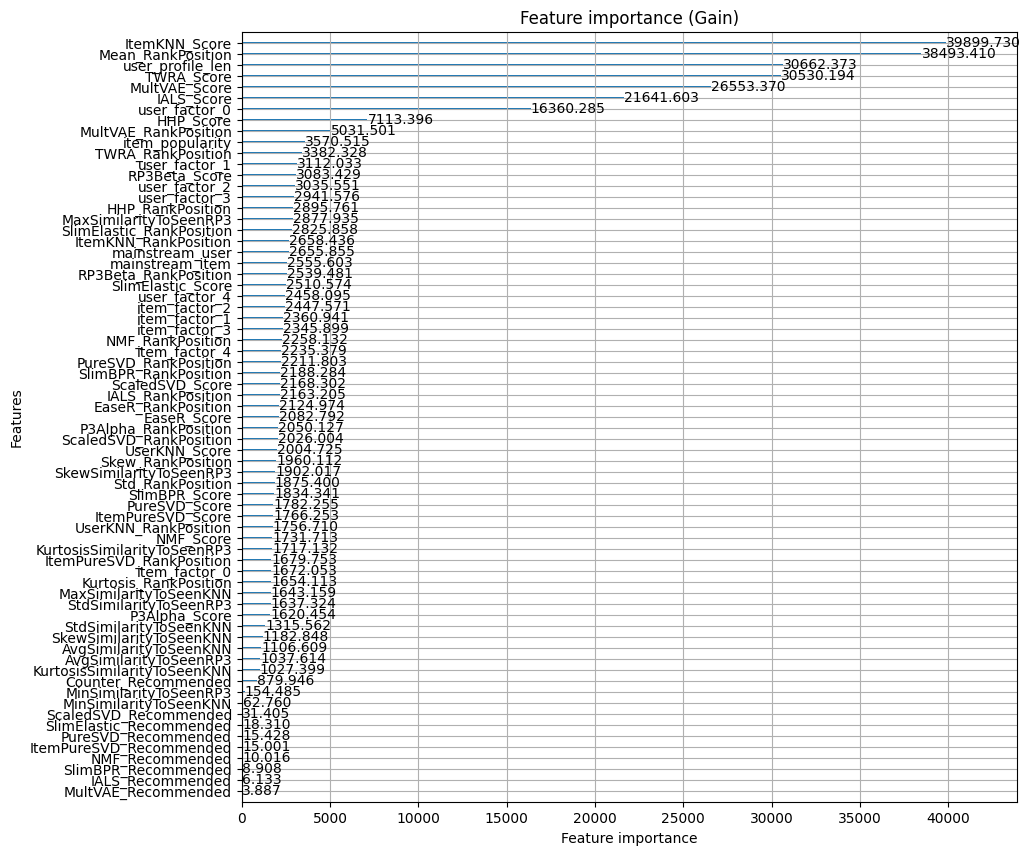

In [40]:
from lightgbm import plot_importance

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_importance(LGBM_model, importance_type='gain', title='Feature importance (Gain)', ax=ax)

<Axes: title={'center': 'Feature importance (Split)'}, xlabel='Feature importance', ylabel='Features'>

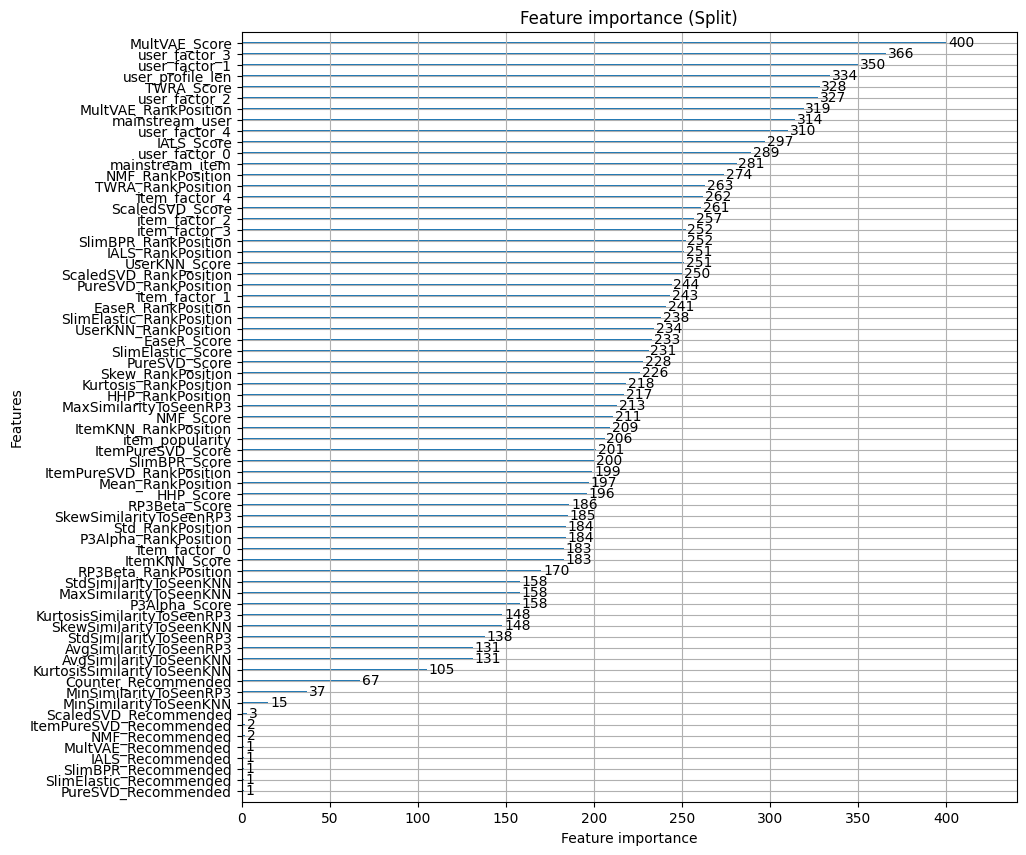

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_importance(LGBM_model, importance_type='split', title='Feature importance (Split)', ax=ax)

In [42]:
recommender_item = ItemKNNCFRecommender(URM_train_complete)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_train_complete)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_train_complete)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_train_complete)
recommender_p3a.fit(**params_p3alpha)

recommender_pure_svd = PureSVDRecommender(URM_train_complete)
recommender_pure_svd.fit(num_factors=params_pure_svd['factors'])

recommender_scaled_svd = ScaledPureSVDRecommender(URM_train_complete)
recommender_scaled_svd.fit(**params_scaled)

recommender_pure_svd_item = PureSVDItemRecommender(URM_train_complete)
recommender_pure_svd_item.fit(**params_pure_svd_item)

recommender_nmf = NMFRecommender(URM_train_complete)
recommender_nmf.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'nmf_train_validation.zip')

recommender_slim_bpr = SLIM_BPR_Python(URM_train_complete)
recommender_slim_bpr.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_bpr_train_validation.zip')

recommender_slim = SLIMElasticNetRecommender(URM_train_complete)
recommender_slim.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_elastic_train_validation.zip')

recommender_ease_r = EASE_R_Recommender(URM_train_complete)
recommender_ease_r.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'ease_r_train_validation.zip')

recommender_ials = IALSRecommender(URM_train_complete)
recommender_ials.load_model('/kaggle/working/', 'ials_train_validation.zip')

recommender_vae = MultVAERecommender(URM_train_complete)
recommender_vae.load_model('/kaggle/working/', 'mult_vae_2_train_validation')

recommender_hhp = HHPRecommender(URM_train_complete)
recommender_hhp.fit(**params_hhp)

recommender_twra = TwoWayRankAggregationRecommender(URM_train_complete)
recommender_twra.fit(**params_twra)

# recommender_als = ALSImplicitRecommender(URM_train_complete)
# recommender_als.load_model('/kaggle/working/', 'als_train_validation.npz')

########################## CANDIDATE GENERATORS ##########################

recommender_slim_recall = SLIMElasticNetRecommender(URM_train_complete)
recommender_slim_recall.load_model('/kaggle/working/', 'slim_recall_train_validation.zip')

recommender_rp3_recall = RP3betaRecommender(URM_train_complete)
recommender_rp3_recall.fit(**params_rp3_recall)

recommender_item_recall = ItemKNNCFRecommender(URM_train_complete)
recommender_item_recall.fit(**params_item_knn_recall)

ItemKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Similarity column 22347 (100.0%), 4633.67 column/sec. Elapsed time 4.82 sec
UserKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 4812.61 column/sec. Elapsed time 2.71 sec
RP3betaRecommender: URM Detected 627 ( 4.8%) users with no interactions.
RP3betaRecommender: URM Detected 247 ( 1.1%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 2508.62 column/sec. Elapsed time 8.91 sec
P3alphaRecommender: URM Detected 627 ( 4.8%) users with no interactions.
P3alphaRecommender: URM Detected 247 ( 1.1%) items with no interactions.
P3alphaRecommender: Similarity column 22347 (100.0%), 3072.92 column/sec. Elapsed time 7.27 sec
PureSVDRecommender: URM Detected 627 ( 4.8%) users with no inter

In [43]:
recommender_object_dict = {
    'ItemKNN': recommender_item,
    'UserKNN': recommender_user,
    'P3Alpha': recommender_p3a,
    'RP3Beta': recommender_rp3,
    'NMF': recommender_nmf,
    'PureSVD': recommender_pure_svd,
    'ScaledSVD': recommender_scaled_svd,
    'ItemPureSVD': recommender_pure_svd_item,
    'SlimElastic': recommender_slim,
    'SlimBPR': recommender_slim_bpr,
    'EaseR': recommender_ease_r,
    'IALS': recommender_ials,
    'MultVAE': recommender_vae,
    'HHP': recommender_hhp,
    'TWRA': recommender_twra,
    # 'ALS': recommender_als
}

In [44]:
cutoff = 50
n_users, n_items = URM_train_complete.shape

validation_dataframe = pd.DataFrame(index=range(0, n_users), columns = ["ItemID"])
validation_dataframe.index.name='UserID'

for user_id in tqdm.auto.tqdm(range(n_users)):    
    recommendations_slim = recommender_slim_recall.recommend(user_id, cutoff = cutoff)
    recommendations_knn = recommender_item_recall.recommend(user_id, cutoff = cutoff)
    recommendations_rp3 = recommender_rp3_recall.recommend(user_id, cutoff = cutoff)
    recommendations = np.union1d(recommendations_slim, np.union1d(recommendations_knn, recommendations_rp3))
    validation_dataframe.loc[user_id, "ItemID"] = recommendations
    
validation_dataframe = validation_dataframe.explode("ItemID")

for label, recommender in tqdm.auto.tqdm(recommender_object_dict.items()):
    scores = recommender._compute_item_score(np.arange(n_users))
    linf_scores = scores / (LA.norm(scores, np.inf, axis=1, keepdims=True) + 1e-6)
    
    for user_id in tqdm.auto.tqdm(range(n_users)):
        item_list = validation_dataframe.loc[user_id, "ItemID"].values.tolist()
        linf_scores[user_id, :] = recommender._remove_seen_on_scores(user_id, linf_scores[user_id, :])
        validation_dataframe.loc[user_id, f"{label}_Score"] = linf_scores[user_id, item_list]
        
        rank = np.argsort(linf_scores[user_id, :])[::-1]
        positions = np.zeros(n_items, dtype=int)
        positions[rank] = np.arange(n_items)
        validation_dataframe.loc[user_id, f"{label}_RankPosition"] = positions[item_list]
        
        recommended = np.isin(item_list, rank[:10], assume_unique=True)
        validation_dataframe.loc[user_id, f"{label}_Recommended"] = recommended.astype(int)
    
    del scores, linf_scores, rank, positions, recommended
    gc.collect()
    
item_item_S = recommender_item.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        validation_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = 0
        validation_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = 0
        validation_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = 0
        validation_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = 0
        validation_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = 0
        validation_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = 0
    else:
        similarities = item_item_S[validation_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        validation_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = similarities.mean(axis=1).flatten()
        validation_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = similarities.max(axis=1).flatten()
        validation_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = similarities.min(axis=1).flatten()
        validation_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = similarities.std(axis=1).flatten()
        validation_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = stats.skew(similarities, axis=1)
        validation_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

item_item_S = recommender_rp3.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        validation_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = 0
        validation_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = 0
        validation_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = 0
        validation_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = 0
        validation_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = 0
        validation_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = 0
    else:
        similarities = item_item_S[validation_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        validation_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = similarities.mean(axis=1).flatten()
        validation_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = similarities.max(axis=1).flatten()
        validation_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = similarities.min(axis=1).flatten()
        validation_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = similarities.std(axis=1).flatten()
        validation_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = stats.skew(similarities, axis=1)
        validation_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()
    
validation_dataframe = validation_dataframe.reset_index()
validation_dataframe = validation_dataframe.rename(columns = {"index": "UserID"})

recommended_columns = [col for col in validation_dataframe.columns if col.endswith('_Recommended')]
validation_dataframe['Counter_Recommended'] = validation_dataframe[recommended_columns].sum(axis=1).astype(int)

position_columns = [col for col in validation_dataframe.columns if col.endswith('_RankPosition')]
validation_dataframe['Mean_RankPosition'] = validation_dataframe[position_columns].mean(axis=1)
validation_dataframe['Std_RankPosition'] = validation_dataframe[position_columns].std(axis=1)
validation_dataframe['Skew_RankPosition'] = validation_dataframe[position_columns].skew(axis=1)
validation_dataframe['Kurtosis_RankPosition'] = validation_dataframe[position_columns].kurtosis(axis=1)

item_popularity = np.ediff1d(sps.csc_matrix(URM_train_complete).indptr)
item_popularity = item_popularity / np.max(item_popularity)
validation_dataframe['item_popularity'] = item_popularity[validation_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(URM_train_complete).indptr)
user_popularity = user_popularity / np.max(user_popularity)
validation_dataframe['user_profile_len'] = user_popularity[validation_dataframe["UserID"].values.astype(int)]
validation_dataframe

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

/tmp/ipykernel_18/626954395.py:52: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  validation_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = stats.skew(similarities, axis=1)
/tmp/ipykernel_18/626954395.py:53: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  validation_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = stats.kurtosis(similarities, axis=1)


  0%|          | 0/13024 [00:00<?, ?it/s]

,UserID,ItemID,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,P3Alpha_RankPosition,...,StdSimilarityToSeenRP3,SkewSimilarityToSeenRP3,KurtosisSimilarityToSeenRP3,Counter_Recommended,Mean_RankPosition,Std_RankPosition,Skew_RankPosition,Kurtosis_RankPosition,item_popularity,user_profile_len
0,0,0,0.000000,22303.0,0.0,0.005663,133.0,0.0,0.000000,22283.0,...,0.000000,NaN,NaN,0,9161.133333,11034.608795,0.438419,-2.085587,0.886121,0.032075
1,0,1,0.000000,7499.0,0.0,0.010246,60.0,0.0,0.000000,7477.0,...,0.000000,NaN,NaN,0,2885.733333,3500.712631,0.552869,-1.858036,1.000000,0.032075
2,0,2,0.000000,7500.0,0.0,0.010817,58.0,0.0,0.000000,7478.0,...,0.000000,NaN,NaN,1,6237.600000,6386.778987,0.997782,1.376678,0.811388,0.032075
3,0,3,0.000000,7501.0,0.0,0.012973,51.0,0.0,0.000000,7479.0,...,0.000000,NaN,NaN,0,4538.666667,5393.305780,1.002611,0.534822,0.973665,0.032075
4,0,7,0.189751,24.0,0.0,0.008546,73.0,0.0,0.113997,12.0,...,0.000000,NaN,NaN,1,1604.933333,4586.695721,3.231686,10.715886,0.692527,0.032075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1055398,13023,10912,0.124691,41.0,0.0,0.077127,408.0,0.0,0.030217,154.0,...,0.011540,2.528026,4.419128,0,2355.066667,4825.602456,3.269872,11.517487,0.004982,0.056604
1055399,13023,11018,0.149842,36.0,0.0,0.163464,120.0,0.0,0.147351,30.0,...,0.011594,2.325696,3.618560,0,171.733333,255.100111,1.943374,2.761437,0.004982,0.056604
1055400,13023,11653,0.248895,16.0,0.0,0.164520,118.0,0.0,0.305779,12.0,...,0.013050,3.435117,10.790638,2,115.800000,167.459675,2.053184,4.202460,0.007117,0.056604
1055401,13023,11955,0.260745,15.0,0.0,0.157063,126.0,0.0,0.138857,32.0,...,0.014879,2.872438,6.805297,0,194.533333,377.837241,2.745526,7.327920,0.004982,0.056604


In [45]:
mainstream_user = URM_train_complete.dot(item_popularity) / np.where(user_popularity == 0, 1, user_popularity)
validation_dataframe['mainstream_user'] = mainstream_user[validation_dataframe["UserID"].values.astype(int)]

mainstream_item = URM_train_complete.T.dot(user_popularity) / np.where(item_popularity == 0, 1, item_popularity)
validation_dataframe['mainstream_item'] = mainstream_item[validation_dataframe["ItemID"].values.astype(int)]

user_factors_df = pd.DataFrame(user_factors_train[:, :5], columns=[f'user_factor_{i}' for i in range(user_factors_train[:, :5].shape[1])])
item_factors_df = pd.DataFrame(item_factors_train[:, :5], columns=[f'item_factor_{i}' for i in range(item_factors_train[:, :5].shape[1])])
validation_dataframe = validation_dataframe.merge(item_factors_df, left_on='ItemID', right_index=True)
validation_dataframe = validation_dataframe.merge(user_factors_df, left_on='UserID', right_index=True)
validation_dataframe = validation_dataframe.sort_values(by='UserID')

validation_dataframe

,UserID,ItemID,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,P3Alpha_RankPosition,...,item_factor_0,item_factor_1,item_factor_2,item_factor_3,item_factor_4,user_factor_0,user_factor_1,user_factor_2,user_factor_3,user_factor_4
0,0,0,0.000000,22303.0,0.0,0.005663,133.0,0.0,0.000000,22283.0,...,0.163921,0.090707,-0.216788,-0.041741,0.056197,0.005684,-0.001896,0.008995,-0.013853,-0.002147
60,0,1257,0.113153,50.0,0.0,0.002463,460.0,0.0,0.055753,56.0,...,0.009264,0.007807,0.009192,0.015810,0.004970,0.005684,-0.001896,0.008995,-0.013853,-0.002147
59,0,1213,0.219015,17.0,0.0,0.004029,208.0,0.0,0.086829,25.0,...,0.007796,-0.009614,0.002953,-0.000483,-0.004862,0.005684,-0.001896,0.008995,-0.013853,-0.002147
58,0,1088,0.206087,20.0,0.0,0.000000,9783.0,0.0,0.063827,43.0,...,0.011467,-0.011217,0.021460,0.020043,0.052159,0.005684,-0.001896,0.008995,-0.013853,-0.002147
57,0,1082,0.261194,14.0,0.0,0.003559,265.0,0.0,0.101984,16.0,...,0.008902,-0.013901,0.005310,0.008307,0.003830,0.005684,-0.001896,0.008995,-0.013853,-0.002147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1055380,13023,2152,0.000000,5872.0,0.0,0.216950,65.0,0.0,0.000000,5857.0,...,0.004974,-0.014541,0.004915,0.004194,0.023232,0.006896,-0.007143,0.001571,0.006195,0.023549
1055379,13023,2119,0.487735,4.0,1.0,0.364687,11.0,0.0,0.439395,7.0,...,0.003394,-0.009902,0.004116,0.002884,0.015884,0.006896,-0.007143,0.001571,0.006195,0.023549
1055381,13023,2195,0.296294,11.0,0.0,0.290332,27.0,0.0,0.251844,15.0,...,0.004869,-0.011313,0.006562,-0.000144,0.018232,0.006896,-0.007143,0.001571,0.006195,0.023549
1055377,13023,1791,0.034666,147.0,0.0,0.248859,40.0,0.0,0.050318,88.0,...,0.006689,-0.014163,0.015855,0.009517,0.029980,0.006896,-0.007143,0.001571,0.006195,0.023549


In [46]:
# validation_dataframe["UserID"] = validation_dataframe["UserID"].astype("category")
# validation_dataframe["ItemID"] = validation_dataframe["ItemID"].astype("category")

validation_dataframe["UserID"] = validation_dataframe["UserID"].astype(int)
validation_dataframe["ItemID"] = validation_dataframe["ItemID"].astype(int)

# object_columns = validation_dataframe.select_dtypes(include=['object']).columns
# validation_dataframe[object_columns] = validation_dataframe[object_columns].astype('category')

In [47]:
class LightGBMRerankerRecommender:
    def __init__(self, URM_train, LGBM_model, df):
        self.URM_train = URM_train
        self.df = df
        self.LGBM_model = LGBM_model
        
    def recommend(self, user_ids, cutoff=10, return_scores=True, remove_seen_flag=True, remove_top_pop_flag=True, remove_custom_items_flag=False):
        recommendations = []
        for user_id in user_ids:
            df_slice = self.df[self.df['UserID'] == user_id]
            items = df_slice.ItemID.to_numpy()
            preds = self.LGBM_model.predict_proba(df_slice.drop(columns=["UserID", "ItemID"]))[:, 1].flatten()
            recommendations.append(items[np.argsort(preds)[-cutoff:][::-1]].tolist())
            
        if return_scores:
            rec, scores = recommender_item.recommend(user_ids, cutoff=cutoff, return_scores=return_scores)
            # useless scores
            return np.array(recommendations), scores
        return np.array(recommendations)
    
    def get_URM_train(self):
        return self.URM_train

In [48]:
recommender = LightGBMRerankerRecommender(URM_train_complete, LGBM_model, validation_dataframe)
result_df, _ = evaluator.evaluateRecommender(recommender)
result_df

EvaluatorHoldout: Processed 10456 (100.0%) in 1.14 min. Users per second: 153


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.098212,0.170988,0.144883,0.048959,0.083525,0.272648,0.152855,0.117067,0.536725,0.361086,...,0.802826,0.430897,0.802826,0.056845,10.103821,0.997038,0.164019,0.778359,2.044248,0.29441


In [49]:
def objective_xgboost(trial):

    LGBM_model = LGBMClassifier(
        objective = trial.suggest_categorical('objective', ["binary", "cross_entropy", "cross_entropy_lambda"]),
        n_estimators = trial.suggest_int('n_estimators', 10, 5000, log=True),
        learning_rate = trial.suggest_float('learning_rate', 1e-4, 0.5, log=True),
        reg_alpha = trial.suggest_float('reg_alpha', 1e-5, 1, log=True),
        reg_lambda = trial.suggest_float('reg_lambda', 1e-5, 1, log=True),
        max_depth = trial.suggest_int('max_depth', 3, 20),
        num_leaves = trial.suggest_int('num_leaves', 8, 1024),
        boosting_type = "gbdt",
        min_split_gain = trial.suggest_float('min_split_gain', 1e-7, 10, log=True),
        min_child_weight = trial.suggest_float('min_child_weight', 1e-7, 1, log=True),
        min_child_samples = trial.suggest_int('min_child_samples', 5, 200),
        subsample = trial.suggest_float('subsample', 0.1, 0.9),
        subsample_freq = trial.suggest_int('subsample_freq', 1, 20),
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 0.9)
    )
    
    LGBM_model.fit(
        X_train,
        y_train,
    )
    
    recommender = LightGBMRerankerRecommender(URM_train_complete, LGBM_model, validation_dataframe)
    result_df, _ = evaluator.evaluateRecommender(recommender)
        
    return result_df.loc[10, 'MAP']

In [50]:
try:
    shutil.copyfile(
        '/kaggle/working/Recsys_Challenge_2023/tuning_results/tuning_hybrid_lightgbm_classifier_no_ids.db', 
        config['database_path']
    )
except FileNotFoundError:
    pass

In [51]:
if config['tune_parameters']:
    study = optuna.create_study(direction='maximize', study_name='lightgbm_classifier_no_ids_tuning', 
                                storage=f'sqlite:///{config["database_path"]}', load_if_exists=True)
    study.optimize(objective_xgboost, n_trials=config['n_trials'])

[I 2023-12-30 00:25:36,254] Using an existing study with name 'lightgbm_classifier_no_ids_tuning' instead of creating a new one.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.16 min. Users per second: 81


[I 2023-12-30 00:30:21,507] Trial 130 finished with value: 0.052163521969614456 and parameters: {'objective': 'cross_entropy', 'n_estimators': 1266, 'learning_rate': 0.001710584663457669, 'reg_alpha': 0.000889342761281862, 'reg_lambda': 2.3698423344471918e-05, 'max_depth': 7, 'num_leaves': 197, 'min_split_gain': 3.546903081675484e-05, 'min_child_weight': 0.06328752800941598, 'min_child_samples': 180, 'subsample': 0.284301672757446, 'subsample_freq': 15, 'colsample_bytree': 0.1892701745511584}. Best is trial 89 with value: 0.052684791750161206.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.38 min. Users per second: 73


[I 2023-12-30 00:35:26,029] Trial 131 finished with value: 0.0524673347724711 and parameters: {'objective': 'cross_entropy', 'n_estimators': 1850, 'learning_rate': 0.0029426638164074376, 'reg_alpha': 0.0006182733014294033, 'reg_lambda': 1.5254195414606358e-05, 'max_depth': 6, 'num_leaves': 102, 'min_split_gain': 1.4300608162200148e-05, 'min_child_weight': 0.11091924365505638, 'min_child_samples': 193, 'subsample': 0.3016514935928085, 'subsample_freq': 16, 'colsample_bytree': 0.1833075506916143}. Best is trial 89 with value: 0.052684791750161206.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.22 min. Users per second: 78


[I 2023-12-30 00:39:56,297] Trial 132 finished with value: 0.05227451618877623 and parameters: {'objective': 'cross_entropy', 'n_estimators': 1458, 'learning_rate': 0.002115388569931901, 'reg_alpha': 0.0003587308702963747, 'reg_lambda': 2.163423827365569e-05, 'max_depth': 8, 'num_leaves': 73, 'min_split_gain': 6.673657545944284e-06, 'min_child_weight': 0.08632340555267334, 'min_child_samples': 187, 'subsample': 0.2585698405133403, 'subsample_freq': 15, 'colsample_bytree': 0.15805647177844764}. Best is trial 89 with value: 0.052684791750161206.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.75 min. Users per second: 99


[I 2023-12-30 00:43:22,469] Trial 133 finished with value: 0.0520760807192046 and parameters: {'objective': 'cross_entropy', 'n_estimators': 1153, 'learning_rate': 0.002532649682378887, 'reg_alpha': 0.0004829821332167109, 'reg_lambda': 3.223515244814979e-05, 'max_depth': 7, 'num_leaves': 35, 'min_split_gain': 2.716123831755871e-06, 'min_child_weight': 0.045030222541791565, 'min_child_samples': 173, 'subsample': 0.33175821277109463, 'subsample_freq': 18, 'colsample_bytree': 0.20020276769859538}. Best is trial 89 with value: 0.052684791750161206.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.92 min. Users per second: 91


[I 2023-12-30 00:46:58,516] Trial 134 finished with value: 0.05221314032499041 and parameters: {'objective': 'cross_entropy', 'n_estimators': 977, 'learning_rate': 0.0033678806177141777, 'reg_alpha': 0.0007306902366158405, 'reg_lambda': 1.9272041581307185e-05, 'max_depth': 8, 'num_leaves': 110, 'min_split_gain': 1.9142093706429403e-05, 'min_child_weight': 0.14736827893859814, 'min_child_samples': 182, 'subsample': 0.2775978837304811, 'subsample_freq': 15, 'colsample_bytree': 0.12052465158259966}. Best is trial 89 with value: 0.052684791750161206.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.39 min. Users per second: 73


[I 2023-12-30 00:51:55,810] Trial 135 finished with value: 0.051850429919481564 and parameters: {'objective': 'cross_entropy', 'n_estimators': 1910, 'learning_rate': 0.0014255330907481953, 'reg_alpha': 0.00042511667044678567, 'reg_lambda': 3.792458533720308e-05, 'max_depth': 6, 'num_leaves': 149, 'min_split_gain': 8.074772460267525e-06, 'min_child_weight': 0.1262626014490395, 'min_child_samples': 177, 'subsample': 0.23854371896997495, 'subsample_freq': 16, 'colsample_bytree': 0.17478913371090474}. Best is trial 89 with value: 0.052684791750161206.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.69 min. Users per second: 65


[I 2023-12-30 00:57:38,713] Trial 136 finished with value: 0.05236938842739382 and parameters: {'objective': 'cross_entropy', 'n_estimators': 2225, 'learning_rate': 0.003150294856603134, 'reg_alpha': 0.00010960998517729883, 'reg_lambda': 2.608167839945648e-05, 'max_depth': 7, 'num_leaves': 49, 'min_split_gain': 1.1057915176734879e-05, 'min_child_weight': 0.0353012067652877, 'min_child_samples': 190, 'subsample': 0.29943347263915204, 'subsample_freq': 14, 'colsample_bytree': 0.13248771292546027}. Best is trial 89 with value: 0.052684791750161206.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.43 min. Users per second: 72


[I 2023-12-30 01:02:38,293] Trial 137 finished with value: 0.052049673765196244 and parameters: {'objective': 'cross_entropy', 'n_estimators': 1617, 'learning_rate': 0.0059752475102626025, 'reg_alpha': 0.0012981895418349859, 'reg_lambda': 4.67065642249647e-05, 'max_depth': 7, 'num_leaves': 90, 'min_split_gain': 6.176794327784047e-05, 'min_child_weight': 0.06457760608345568, 'min_child_samples': 185, 'subsample': 0.3436500282997249, 'subsample_freq': 15, 'colsample_bytree': 0.10230478001728396}. Best is trial 89 with value: 0.052684791750161206.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.66 min. Users per second: 105


[I 2023-12-30 01:05:50,433] Trial 138 finished with value: 0.05220623307343874 and parameters: {'objective': 'cross_entropy', 'n_estimators': 896, 'learning_rate': 0.0038327919789137117, 'reg_alpha': 0.002464127136008871, 'reg_lambda': 1.4797657464881288e-05, 'max_depth': 9, 'num_leaves': 60, 'min_split_gain': 2.738666835870813e-05, 'min_child_weight': 0.19786315389847692, 'min_child_samples': 197, 'subsample': 0.3877214954943651, 'subsample_freq': 15, 'colsample_bytree': 0.15331973612799754}. Best is trial 89 with value: 0.052684791750161206.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.87 min. Users per second: 93


[I 2023-12-30 01:09:43,955] Trial 139 finished with value: 0.05234499292576035 and parameters: {'objective': 'cross_entropy', 'n_estimators': 1404, 'learning_rate': 0.002295986488167242, 'reg_alpha': 0.00031590862296255095, 'reg_lambda': 6.266000263882271e-05, 'max_depth': 8, 'num_leaves': 33, 'min_split_gain': 3.4074356646057954e-06, 'min_child_weight': 0.09063923929380735, 'min_child_samples': 166, 'subsample': 0.31056302482470666, 'subsample_freq': 14, 'colsample_bytree': 0.242884067559845}. Best is trial 89 with value: 0.052684791750161206.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.39 min. Users per second: 51


[I 2023-12-30 01:17:34,958] Trial 140 finished with value: 0.05208019091339722 and parameters: {'objective': 'cross_entropy', 'n_estimators': 1996, 'learning_rate': 0.0048273321098199215, 'reg_alpha': 0.0009241611427581915, 'reg_lambda': 3.806333635555434e-05, 'max_depth': 13, 'num_leaves': 120, 'min_split_gain': 0.00010992325119998656, 'min_child_weight': 0.018353401823568646, 'min_child_samples': 171, 'subsample': 0.3703810078374425, 'subsample_freq': 16, 'colsample_bytree': 0.1995141412494018}. Best is trial 89 with value: 0.052684791750161206.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.02 min. Users per second: 86


[I 2023-12-30 01:22:09,605] Trial 141 finished with value: 0.052283525977338534 and parameters: {'objective': 'cross_entropy', 'n_estimators': 2325, 'learning_rate': 0.004154029469431447, 'reg_alpha': 0.00027326564583209144, 'reg_lambda': 2.8335434451940588e-05, 'max_depth': 7, 'num_leaves': 8, 'min_split_gain': 4.9955183174519845e-06, 'min_child_weight': 0.23770589082448676, 'min_child_samples': 182, 'subsample': 0.3256665559610483, 'subsample_freq': 13, 'colsample_bytree': 0.2141322786391866}. Best is trial 89 with value: 0.052684791750161206.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.10 min. Users per second: 56


[I 2023-12-30 01:29:16,375] Trial 142 finished with value: 0.05262925668864869 and parameters: {'objective': 'cross_entropy', 'n_estimators': 2997, 'learning_rate': 0.002781192029966491, 'reg_alpha': 0.00019459280626142662, 'reg_lambda': 7.054621414732484e-05, 'max_depth': 6, 'num_leaves': 34, 'min_split_gain': 1.4057014297825264e-05, 'min_child_weight': 0.37642404335842977, 'min_child_samples': 186, 'subsample': 0.2895491377681645, 'subsample_freq': 14, 'colsample_bytree': 0.2264491300453193}. Best is trial 89 with value: 0.052684791750161206.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.75 min. Users per second: 63


[I 2023-12-30 01:35:36,537] Trial 143 finished with value: 0.052312991857033996 and parameters: {'objective': 'cross_entropy', 'n_estimators': 2863, 'learning_rate': 0.002797915380372494, 'reg_alpha': 0.00019723030453524132, 'reg_lambda': 7.7794696462872e-05, 'max_depth': 5, 'num_leaves': 31, 'min_split_gain': 1.2830318903624142e-05, 'min_child_weight': 0.4231860521085904, 'min_child_samples': 192, 'subsample': 0.27108645272286247, 'subsample_freq': 14, 'colsample_bytree': 0.2601061241765769}. Best is trial 89 with value: 0.052684791750161206.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.26 min. Users per second: 77


[I 2023-12-30 01:40:26,618] Trial 144 finished with value: 0.05227971939859898 and parameters: {'objective': 'cross_entropy', 'n_estimators': 1681, 'learning_rate': 0.0019042456729096858, 'reg_alpha': 0.0006102998676213991, 'reg_lambda': 5.5533212192041205e-05, 'max_depth': 6, 'num_leaves': 73, 'min_split_gain': 4.740790833366902e-05, 'min_child_weight': 0.6969548501812058, 'min_child_samples': 178, 'subsample': 0.28473710778489275, 'subsample_freq': 15, 'colsample_bytree': 0.23017505003420244}. Best is trial 89 with value: 0.052684791750161206.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.88 min. Users per second: 93


[I 2023-12-30 01:44:08,360] Trial 145 finished with value: 0.052411852843662655 and parameters: {'objective': 'cross_entropy', 'n_estimators': 1137, 'learning_rate': 0.0033630544283213787, 'reg_alpha': 0.0001337745971037751, 'reg_lambda': 6.842773986322932e-05, 'max_depth': 8, 'num_leaves': 52, 'min_split_gain': 8.705299174792201e-06, 'min_child_weight': 0.05235856651382187, 'min_child_samples': 188, 'subsample': 0.34946621356964697, 'subsample_freq': 14, 'colsample_bytree': 0.19047502681537232}. Best is trial 89 with value: 0.052684791750161206.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.05 min. Users per second: 57


[I 2023-12-30 01:50:46,294] Trial 146 finished with value: 0.0523622041267418 and parameters: {'objective': 'cross_entropy', 'n_estimators': 2524, 'learning_rate': 0.002506018673730343, 'reg_alpha': 7.34623780813154e-05, 'reg_lambda': 9.855750725901134e-05, 'max_depth': 6, 'num_leaves': 78, 'min_split_gain': 1.9219516046522266e-05, 'min_child_weight': 0.17022804101836722, 'min_child_samples': 185, 'subsample': 0.2970246267472768, 'subsample_freq': 13, 'colsample_bytree': 0.1677751290275564}. Best is trial 89 with value: 0.052684791750161206.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.14 min. Users per second: 56


[I 2023-12-30 01:57:44,587] Trial 147 finished with value: 0.050904569108950026 and parameters: {'objective': 'cross_entropy', 'n_estimators': 2026, 'learning_rate': 0.007137514258523968, 'reg_alpha': 0.00016408320333914314, 'reg_lambda': 5.0441336514753895e-05, 'max_depth': 9, 'num_leaves': 101, 'min_split_gain': 6.7881200405789785e-06, 'min_child_weight': 0.35063432655543175, 'min_child_samples': 174, 'subsample': 0.2558179887208056, 'subsample_freq': 17, 'colsample_bytree': 0.24497457434106035}. Best is trial 89 with value: 0.052684791750161206.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.65 min. Users per second: 66


[I 2023-12-30 02:04:06,582] Trial 148 finished with value: 0.05281998791610528 and parameters: {'objective': 'cross_entropy', 'n_estimators': 2709, 'learning_rate': 0.0053208540659532835, 'reg_alpha': 0.0003580625487934924, 'reg_lambda': 0.0001586665480537507, 'max_depth': 5, 'num_leaves': 28, 'min_split_gain': 3.173872464167416e-05, 'min_child_weight': 0.12147569010862018, 'min_child_samples': 194, 'subsample': 0.3237242402523125, 'subsample_freq': 16, 'colsample_bytree': 0.29082182047324445}. Best is trial 148 with value: 0.05281998791610528.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.10 min. Users per second: 83


[I 2023-12-30 02:08:46,418] Trial 149 finished with value: 0.05247694799674557 and parameters: {'objective': 'cross_entropy', 'n_estimators': 1789, 'learning_rate': 0.0038499176849009762, 'reg_alpha': 0.0005290137872035458, 'reg_lambda': 0.0001565516966494969, 'max_depth': 5, 'num_leaves': 412, 'min_split_gain': 2.9954168331426538e-05, 'min_child_weight': 0.1201440019866484, 'min_child_samples': 195, 'subsample': 0.3321900073413733, 'subsample_freq': 16, 'colsample_bytree': 0.27114410166622327}. Best is trial 148 with value: 0.05281998791610528.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.39 min. Users per second: 73


[I 2023-12-30 02:14:29,240] Trial 150 finished with value: 0.05241822497297857 and parameters: {'objective': 'cross_entropy', 'n_estimators': 2251, 'learning_rate': 0.0029808387350933716, 'reg_alpha': 0.00010137619445477577, 'reg_lambda': 0.00024467298065118583, 'max_depth': 7, 'num_leaves': 24, 'min_split_gain': 4.131038971443168e-05, 'min_child_weight': 0.5041478789569653, 'min_child_samples': 200, 'subsample': 0.35706989234546027, 'subsample_freq': 15, 'colsample_bytree': 0.2898879708474793}. Best is trial 148 with value: 0.05281998791610528.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.07 min. Users per second: 84


[I 2023-12-30 02:19:11,127] Trial 151 finished with value: 0.05260161250167019 and parameters: {'objective': 'cross_entropy', 'n_estimators': 1784, 'learning_rate': 0.003798668840253779, 'reg_alpha': 0.0005277951784706106, 'reg_lambda': 0.00015389724989128695, 'max_depth': 5, 'num_leaves': 50, 'min_split_gain': 2.8135353406054998e-05, 'min_child_weight': 0.10550338784666251, 'min_child_samples': 195, 'subsample': 0.3271609975255133, 'subsample_freq': 16, 'colsample_bytree': 0.31047640623684697}. Best is trial 148 with value: 0.05281998791610528.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.87 min. Users per second: 93


[I 2023-12-30 02:23:10,977] Trial 152 finished with value: 0.05276874901325014 and parameters: {'objective': 'cross_entropy', 'n_estimators': 1455, 'learning_rate': 0.005038206310020477, 'reg_alpha': 0.000368908930459201, 'reg_lambda': 0.00011390732108487834, 'max_depth': 5, 'num_leaves': 56, 'min_split_gain': 1.5188488360950098e-05, 'min_child_weight': 0.2585259732619974, 'min_child_samples': 191, 'subsample': 0.31692573222413845, 'subsample_freq': 16, 'colsample_bytree': 0.315264088098181}. Best is trial 148 with value: 0.05281998791610528.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.88 min. Users per second: 92


[I 2023-12-30 02:27:08,117] Trial 153 finished with value: 0.05253635415528141 and parameters: {'objective': 'cross_entropy', 'n_estimators': 1423, 'learning_rate': 0.005239428590759312, 'reg_alpha': 0.0004017337133029449, 'reg_lambda': 0.00021163763098791384, 'max_depth': 5, 'num_leaves': 56, 'min_split_gain': 2.176137363129354e-05, 'min_child_weight': 0.264495610907203, 'min_child_samples': 193, 'subsample': 0.3211091777468637, 'subsample_freq': 17, 'colsample_bytree': 0.31317139526225496}. Best is trial 148 with value: 0.05281998791610528.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.77 min. Users per second: 98


[I 2023-12-30 02:30:42,616] Trial 154 finished with value: 0.05234899685454422 and parameters: {'objective': 'cross_entropy', 'n_estimators': 1256, 'learning_rate': 0.004932016979640533, 'reg_alpha': 0.0003968975745364824, 'reg_lambda': 0.00019698877314379605, 'max_depth': 5, 'num_leaves': 56, 'min_split_gain': 6.931739213207863e-05, 'min_child_weight': 0.24480870367562502, 'min_child_samples': 195, 'subsample': 0.30148320313589644, 'subsample_freq': 18, 'colsample_bytree': 0.33294998844986345}. Best is trial 148 with value: 0.05281998791610528.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.64 min. Users per second: 106


[I 2023-12-30 02:34:00,248] Trial 155 finished with value: 0.05232640027446872 and parameters: {'objective': 'cross_entropy', 'n_estimators': 1484, 'learning_rate': 0.0063499076096738384, 'reg_alpha': 0.00029892122598053, 'reg_lambda': 0.0001218609675576982, 'max_depth': 5, 'num_leaves': 10, 'min_split_gain': 2.473775637155522e-05, 'min_child_weight': 0.7340225963799659, 'min_child_samples': 190, 'subsample': 0.28418212425095263, 'subsample_freq': 17, 'colsample_bytree': 0.31474624534665363}. Best is trial 148 with value: 0.05281998791610528.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.63 min. Users per second: 107


[I 2023-12-30 02:37:26,130] Trial 156 finished with value: 0.05239551453710835 and parameters: {'objective': 'cross_entropy', 'n_estimators': 1402, 'learning_rate': 0.005076504527957957, 'reg_alpha': 0.0004405804530853809, 'reg_lambda': 0.00016392613767592985, 'max_depth': 4, 'num_leaves': 42, 'min_split_gain': 1.528123269568165e-05, 'min_child_weight': 0.13193389382106657, 'min_child_samples': 200, 'subsample': 0.3138334180261691, 'subsample_freq': 17, 'colsample_bytree': 0.34704396109342955}. Best is trial 148 with value: 0.05281998791610528.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.72 min. Users per second: 101


[I 2023-12-30 02:40:46,810] Trial 157 finished with value: 0.052246913748922486 and parameters: {'objective': 'cross_entropy', 'n_estimators': 1207, 'learning_rate': 0.006446175265884141, 'reg_alpha': 0.00022109817688130063, 'reg_lambda': 0.00023192501732821326, 'max_depth': 5, 'num_leaves': 64, 'min_split_gain': 3.785928864006466e-05, 'min_child_weight': 0.209315566685427, 'min_child_samples': 191, 'subsample': 0.27118499212991765, 'subsample_freq': 16, 'colsample_bytree': 0.32029297791577027}. Best is trial 148 with value: 0.05281998791610528.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.27 min. Users per second: 77


[I 2023-12-30 02:45:51,596] Trial 158 finished with value: 0.052462264394408924 and parameters: {'objective': 'cross_entropy', 'n_estimators': 1853, 'learning_rate': 0.0046062453155682115, 'reg_alpha': 0.0003352247977541635, 'reg_lambda': 9.112749199279756e-05, 'max_depth': 6, 'num_leaves': 36, 'min_split_gain': 8.710447781860582e-05, 'min_child_weight': 0.2932357826742933, 'min_child_samples': 194, 'subsample': 0.3318047556945268, 'subsample_freq': 18, 'colsample_bytree': 0.29120039923241475}. Best is trial 148 with value: 0.05281998791610528.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.32 min. Users per second: 132


[I 2023-12-30 02:48:17,530] Trial 159 finished with value: 0.05211188457147753 and parameters: {'objective': 'cross_entropy', 'n_estimators': 1017, 'learning_rate': 0.009529617823276845, 'reg_alpha': 0.0007630676130534019, 'reg_lambda': 0.0002854972165178407, 'max_depth': 4, 'num_leaves': 8, 'min_split_gain': 2.1378884583001393e-05, 'min_child_weight': 0.4953223030433387, 'min_child_samples': 180, 'subsample': 0.2924422412367306, 'subsample_freq': 16, 'colsample_bytree': 0.2942344169544513}. Best is trial 148 with value: 0.05281998791610528.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.25 min. Users per second: 77


[I 2023-12-30 02:53:28,729] Trial 160 finished with value: 0.052330396612866426 and parameters: {'objective': 'cross_entropy', 'n_estimators': 2074, 'learning_rate': 0.008146153869892666, 'reg_alpha': 0.0005181537845451638, 'reg_lambda': 0.00035954834303900666, 'max_depth': 5, 'num_leaves': 61, 'min_split_gain': 5.213496768709989e-05, 'min_child_weight': 0.9388975010125531, 'min_child_samples': 197, 'subsample': 0.3434132217296808, 'subsample_freq': 17, 'colsample_bytree': 0.3073328535078748}. Best is trial 148 with value: 0.05281998791610528.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.96 min. Users per second: 89


[I 2023-12-30 02:57:55,475] Trial 161 finished with value: 0.05260169599591967 and parameters: {'objective': 'cross_entropy', 'n_estimators': 1634, 'learning_rate': 0.003494819727078816, 'reg_alpha': 0.00019125800214272928, 'reg_lambda': 0.00011198459055827137, 'max_depth': 6, 'num_leaves': 27, 'min_split_gain': 1.7411197464561365e-05, 'min_child_weight': 0.36756239397247564, 'min_child_samples': 188, 'subsample': 0.31867622236503, 'subsample_freq': 16, 'colsample_bytree': 0.3771676537450005}. Best is trial 148 with value: 0.05281998791610528.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.97 min. Users per second: 88


[I 2023-12-30 03:02:14,786] Trial 162 finished with value: 0.05260443233018828 and parameters: {'objective': 'cross_entropy', 'n_estimators': 1597, 'learning_rate': 0.003931392506208585, 'reg_alpha': 0.00020089110831347212, 'reg_lambda': 0.00012051878484430339, 'max_depth': 6, 'num_leaves': 28, 'min_split_gain': 1.3761088700707277e-05, 'min_child_weight': 0.37823576598875175, 'min_child_samples': 189, 'subsample': 0.3097259975685741, 'subsample_freq': 16, 'colsample_bytree': 0.34229301064165224}. Best is trial 148 with value: 0.05281998791610528.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.06 min. Users per second: 85


[I 2023-12-30 03:06:50,255] Trial 163 finished with value: 0.052509795393546554 and parameters: {'objective': 'cross_entropy', 'n_estimators': 1609, 'learning_rate': 0.003761108470582539, 'reg_alpha': 0.00019412200539030005, 'reg_lambda': 0.00011599092411046287, 'max_depth': 6, 'num_leaves': 30, 'min_split_gain': 3.0550596047436346e-05, 'min_child_weight': 0.6169511877083159, 'min_child_samples': 189, 'subsample': 0.31769785186698657, 'subsample_freq': 16, 'colsample_bytree': 0.37930308828431797}. Best is trial 148 with value: 0.05281998791610528.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.20 min. Users per second: 79


[I 2023-12-30 03:11:45,203] Trial 164 finished with value: 0.052379521593131514 and parameters: {'objective': 'cross_entropy', 'n_estimators': 1841, 'learning_rate': 0.00551200397168953, 'reg_alpha': 0.0002442874959397237, 'reg_lambda': 0.0001539504236886064, 'max_depth': 6, 'num_leaves': 30, 'min_split_gain': 1.834527743523293e-05, 'min_child_weight': 0.40890327916243596, 'min_child_samples': 192, 'subsample': 0.30686010868301966, 'subsample_freq': 17, 'colsample_bytree': 0.3369277123389687}. Best is trial 148 with value: 0.05281998791610528.


In [52]:
if config['tune_parameters']:
    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()

In [53]:
if config['tune_parameters']:
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

In [54]:
if config['tune_parameters']:
    fig = optuna.visualization.plot_slice(study)
    fig.show()

In [55]:
if config['tune_parameters']:
    with open('/kaggle/working/best_params_lightgbm_classifier_no_ids.json', 'w') as params_file:
        json.dump(study.best_params, params_file)
        
    if config['save_github']: 
        upload_file(
            '/kaggle/working/best_params_lightgbm_classifier_no_ids.json', 
            'tuning_results/best_params_lightgbm_classifier_no_ids.json', 
            'Lightgbm classifier without ids tuning results (from kaggle notebook)'
        )
    
elif config['copy_prev_best_params']:
    shutil.copyfile(
        '/kaggle/input/lightgbm/best_params_lightgbm_classifier_no_ids.json', 
        '/kaggle/working/best_params_lightgbm_classifier_no_ids.json'
    )

In [56]:
if config['save_github'] and config['tune_parameters']:
    upload_file(
        config['database_path'],
        'tuning_results/tuning_hybrid_lightgbm_classifier_no_ids.db', 
        'Lightgbm classifier without ids tuning db updated results (from kaggle notebook)'
    )

In [57]:
with open('/kaggle/working/best_params_lightgbm_classifier_no_ids.json', 'r') as params_file:
    lgbm_params = json.load(params_file)
lgbm_params['boosting_type'] = 'gbdt'
lgbm_params

{'objective': 'cross_entropy',
 'n_estimators': 2709,
 'learning_rate': 0.0053208540659532835,
 'reg_alpha': 0.0003580625487934924,
 'reg_lambda': 0.0001586665480537507,
 'max_depth': 5,
 'num_leaves': 28,
 'min_split_gain': 3.173872464167416e-05,
 'min_child_weight': 0.12147569010862018,
 'min_child_samples': 194,
 'subsample': 0.3237242402523125,
 'subsample_freq': 16,
 'colsample_bytree': 0.29082182047324445,
 'boosting_type': 'gbdt'}

In [58]:
recommender_item = ItemKNNCFRecommender(URM_train_complete)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_train_complete)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_train_complete)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_train_complete)
recommender_p3a.fit(**params_p3alpha)

recommender_pure_svd = PureSVDRecommender(URM_train_complete)
recommender_pure_svd.fit(num_factors=params_pure_svd['factors'])
user_factors_final_train = recommender_pure_svd.USER_factors
item_factors_final_train = recommender_pure_svd.ITEM_factors

recommender_pure_svd_item = PureSVDItemRecommender(URM_train_complete)
recommender_pure_svd_item.fit(**params_pure_svd_item)

recommender_scaled_svd = ScaledPureSVDRecommender(URM_train_complete)
recommender_scaled_svd.fit(**params_scaled)

recommender_nmf = NMFRecommender(URM_train_complete)
recommender_nmf.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'nmf_train_validation.zip')

recommender_slim_bpr = SLIM_BPR_Python(URM_train_complete)
recommender_slim_bpr.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_bpr_train_validation.zip')

recommender_slim = SLIMElasticNetRecommender(URM_train_complete)
recommender_slim.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_elastic_train_validation.zip')

recommender_ease_r = EASE_R_Recommender(URM_train_complete)
recommender_ease_r.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'ease_r_train_validation.zip')

recommender_ials = IALSRecommender(URM_train_complete)
recommender_ials.load_model('/kaggle/working/', 'ials_train_validation.zip')

recommender_vae = MultVAERecommender(URM_train_complete)
recommender_vae.load_model('/kaggle/working/', 'mult_vae_2_train_validation')

recommender_hhp = HHPRecommender(URM_train_complete)
recommender_hhp.fit(**params_hhp)

recommender_twra = TwoWayRankAggregationRecommender(URM_train_complete)
recommender_twra.fit(**params_twra)

# recommender_als = ALSImplicitRecommender(URM_train_complete)
# recommender_als.load_model('/kaggle/working/', 'als_train_validation.npz')

########################## CANDIDATE GENERATORS ##########################

recommender_slim_recall = SLIMElasticNetRecommender(URM_train_complete)
recommender_slim_recall.load_model('/kaggle/working/', 'slim_recall_train_validation.zip')

recommender_rp3_recall = RP3betaRecommender(URM_train_complete)
recommender_rp3_recall.fit(**params_rp3_recall)

recommender_item_recall = ItemKNNCFRecommender(URM_train_complete)
recommender_item_recall.fit(**params_item_knn_recall)

ItemKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Similarity column 22347 (100.0%), 4583.18 column/sec. Elapsed time 4.88 sec
UserKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 4680.36 column/sec. Elapsed time 2.78 sec
RP3betaRecommender: URM Detected 627 ( 4.8%) users with no interactions.
RP3betaRecommender: URM Detected 247 ( 1.1%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 2576.03 column/sec. Elapsed time 8.67 sec
P3alphaRecommender: URM Detected 627 ( 4.8%) users with no interactions.
P3alphaRecommender: URM Detected 247 ( 1.1%) items with no interactions.
P3alphaRecommender: Similarity column 22347 (100.0%), 3036.55 column/sec. Elapsed time 7.36 sec
PureSVDRecommender: URM Detected 627 ( 4.8%) users with no inter

In [59]:
recommender_object_dict = {
    'ItemKNN': recommender_item,
    'UserKNN': recommender_user,
    'P3Alpha': recommender_p3a,
    'RP3Beta': recommender_rp3,
    'NMF': recommender_nmf,
    'PureSVD': recommender_pure_svd,
    'ScaledSVD': recommender_scaled_svd,
    'ItemPureSVD': recommender_pure_svd_item,
    'SlimElastic': recommender_slim,
    'SlimBPR': recommender_slim_bpr,
    'EaseR': recommender_ease_r,
    'IALS': recommender_ials,
    'MultVAE': recommender_vae,
    'HHP': recommender_hhp,
    'TWRA': recommender_twra,
    # 'ALS': recommender_als
}

In [60]:
cutoff = 50
n_users, n_items = URM_train_complete.shape

final_train_dataframe = pd.DataFrame(index=range(0, n_users), columns = ["ItemID"])
final_train_dataframe.index.name='UserID'

for user_id in tqdm.tqdm_notebook(range(n_users)):    
    recommendations_slim = recommender_slim_recall.recommend(user_id, cutoff = cutoff)
    recommendations_knn = recommender_item_recall.recommend(user_id, cutoff = cutoff)
    recommendations_rp3 = recommender_rp3_recall.recommend(user_id, cutoff = cutoff)
    recommendations = np.union1d(recommendations_slim, np.union1d(recommendations_knn, recommendations_rp3))
    final_train_dataframe.loc[user_id, "ItemID"] = recommendations
    
final_train_dataframe = final_train_dataframe.explode("ItemID")

URM_test_complete_coo = sps.coo_matrix(URM_test_complete)

correct_recommendations = pd.DataFrame({"UserID": URM_test_complete_coo.row,
                                        "ItemID": URM_test_complete_coo.col})
final_train_dataframe = pd.merge(final_train_dataframe, correct_recommendations, on=['UserID','ItemID'], how='left', indicator='Exist')
final_train_dataframe["Label"] = final_train_dataframe["Exist"] == "both"
final_train_dataframe.drop(columns = ['Exist'], inplace=True)

final_train_dataframe = final_train_dataframe.set_index('UserID')

for label, recommender in tqdm.auto.tqdm(recommender_object_dict.items()):
    scores = recommender._compute_item_score(np.arange(n_users))
    linf_scores = scores / (LA.norm(scores, np.inf, axis=1, keepdims=True) + 1e-6)
    
    for user_id in tqdm.auto.tqdm(range(n_users)):
        item_list = final_train_dataframe.loc[user_id, "ItemID"].values.tolist()
        linf_scores[user_id, :] = recommender._remove_seen_on_scores(user_id, linf_scores[user_id, :])
        final_train_dataframe.loc[user_id, f"{label}_Score"] = linf_scores[user_id, item_list]
        
        rank = np.argsort(linf_scores[user_id, :])[::-1]
        positions = np.zeros(n_items, dtype=int)
        positions[rank] = np.arange(n_items)
        final_train_dataframe.loc[user_id, f"{label}_RankPosition"] = positions[item_list]
        
        recommended = np.isin(item_list, rank[:10], assume_unique=True)
        final_train_dataframe.loc[user_id, f"{label}_Recommended"] = recommended.astype(int)
    
    del scores, linf_scores, rank, positions, recommended
    gc.collect()
    
item_item_S = recommender_item.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        final_train_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = 0
        final_train_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = 0
        final_train_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = 0
        final_train_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = 0
        final_train_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = 0
        final_train_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = 0
    else:
        similarities = item_item_S[final_train_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        final_train_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = similarities.mean(axis=1).flatten()
        final_train_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = similarities.max(axis=1).flatten()
        final_train_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = similarities.min(axis=1).flatten()
        final_train_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = similarities.std(axis=1).flatten()
        final_train_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = stats.skew(similarities, axis=1)
        final_train_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

item_item_S = recommender_rp3.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        final_train_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = 0
        final_train_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = 0
        final_train_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = 0
        final_train_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = 0
        final_train_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = 0
        final_train_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = 0
    else:
        similarities = item_item_S[final_train_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        final_train_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = similarities.mean(axis=1).flatten()
        final_train_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = similarities.max(axis=1).flatten()
        final_train_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = similarities.min(axis=1).flatten()
        final_train_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = similarities.std(axis=1).flatten()
        final_train_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = stats.skew(similarities, axis=1)
        final_train_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

final_train_dataframe = final_train_dataframe.reset_index()
final_train_dataframe = final_train_dataframe.rename(columns = {"index": "UserID"})

recommended_columns = [col for col in final_train_dataframe.columns if col.endswith('_Recommended')]
final_train_dataframe['Counter_Recommended'] = final_train_dataframe[recommended_columns].sum(axis=1).astype(int)

position_columns = [col for col in final_train_dataframe.columns if col.endswith('_RankPosition')]
final_train_dataframe['Mean_RankPosition'] = final_train_dataframe[position_columns].mean(axis=1)
final_train_dataframe['Std_RankPosition'] = final_train_dataframe[position_columns].std(axis=1)
final_train_dataframe['Skew_RankPosition'] = final_train_dataframe[position_columns].skew(axis=1)
final_train_dataframe['Kurtosis_RankPosition'] = final_train_dataframe[position_columns].kurtosis(axis=1)

item_popularity = np.ediff1d(sps.csc_matrix(URM_train_complete).indptr)
item_popularity = item_popularity / np.max(item_popularity)
final_train_dataframe['item_popularity'] = item_popularity[final_train_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(URM_train_complete).indptr)
user_popularity = user_popularity / np.max(user_popularity)
final_train_dataframe['user_profile_len'] = user_popularity[final_train_dataframe["UserID"].values.astype(int)]

mainstream_user = URM_train_complete.dot(item_popularity) / np.where(user_popularity == 0, 1, user_popularity)
final_train_dataframe['mainstream_user'] = mainstream_user[final_train_dataframe["UserID"].values.astype(int)]

mainstream_item = URM_train_complete.T.dot(user_popularity) / np.where(item_popularity == 0, 1, item_popularity)
final_train_dataframe['mainstream_item'] = mainstream_item[final_train_dataframe["ItemID"].values.astype(int)]

user_factors_df = pd.DataFrame(user_factors_final_train[:, :5], columns=[f'user_factor_{i}' for i in range(user_factors_final_train[:, :5].shape[1])])
item_factors_df = pd.DataFrame(item_factors_final_train[:, :5], columns=[f'item_factor_{i}' for i in range(item_factors_final_train[:, :5].shape[1])])

final_train_dataframe = final_train_dataframe.merge(item_factors_df, left_on='ItemID', right_index=True)
final_train_dataframe = final_train_dataframe.merge(user_factors_df, left_on='UserID', right_index=True)
final_train_dataframe = final_train_dataframe.sort_values(by='UserID')
final_train_dataframe

/tmp/ipykernel_18/4000761057.py:7: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

/tmp/ipykernel_18/4000761057.py:62: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.

/tmp/ipykernel_18/4000761057.py:63: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.



  0%|          | 0/13024 [00:00<?, ?it/s]

,UserID,ItemID,Label,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,...,item_factor_0,item_factor_1,item_factor_2,item_factor_3,item_factor_4,user_factor_0,user_factor_1,user_factor_2,user_factor_3,user_factor_4
0,0,0,False,0.000000,22303.0,0.0,0.005663,133.0,0.0,0.000000,...,0.161283,0.057150,-0.179319,-0.017929,0.058489,0.005573,0.000276,0.007794,-0.010626,-0.001530
60,0,1257,False,0.113153,50.0,0.0,0.002463,460.0,0.0,0.055753,...,0.010722,0.007699,0.003787,0.018315,0.003574,0.005573,0.000276,0.007794,-0.010626,-0.001530
59,0,1213,False,0.219015,17.0,0.0,0.004029,208.0,0.0,0.086829,...,0.007025,-0.009459,0.005387,-0.001226,-0.007530,0.005573,0.000276,0.007794,-0.010626,-0.001530
58,0,1088,False,0.206087,20.0,0.0,0.000000,9783.0,0.0,0.063827,...,0.011559,-0.010351,0.023728,0.026254,0.054192,0.005573,0.000276,0.007794,-0.010626,-0.001530
57,0,1082,False,0.261194,14.0,0.0,0.003559,265.0,0.0,0.101984,...,0.009403,-0.015196,0.006102,0.006966,-0.003834,0.005573,0.000276,0.007794,-0.010626,-0.001530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1055380,13023,2152,False,0.000000,5872.0,0.0,0.216950,65.0,0.0,0.000000,...,0.005849,-0.017149,0.009934,0.010005,0.026216,0.009693,-0.007923,-0.000422,0.004503,0.023066
1055379,13023,2119,False,0.487735,4.0,1.0,0.364687,11.0,0.0,0.439395,...,0.004605,-0.013688,0.006540,0.004982,0.021528,0.009693,-0.007923,-0.000422,0.004503,0.023066
1055381,13023,2195,False,0.296294,11.0,0.0,0.290332,27.0,0.0,0.251844,...,0.005514,-0.016249,0.010045,0.002411,0.021653,0.009693,-0.007923,-0.000422,0.004503,0.023066
1055377,13023,1791,False,0.034666,147.0,0.0,0.248859,40.0,0.0,0.050318,...,0.006444,-0.013939,0.017594,0.011301,0.028735,0.009693,-0.007923,-0.000422,0.004503,0.023066


In [61]:
LGBM_model = LGBMClassifier(**lgbm_params)

y_train = final_train_dataframe["Label"].astype(int)
X_train = final_train_dataframe.drop(columns=["Label", "UserID", "ItemID"])

LGBM_model.fit(
    X_train,
    y_train
)

LGBMClassifier(colsample_bytree=0.29082182047324445,
               learning_rate=0.0053208540659532835, max_depth=5,
               min_child_samples=194, min_child_weight=0.12147569010862018,
               min_split_gain=3.173872464167416e-05, n_estimators=2709,
               num_leaves=28, objective='cross_entropy',
               reg_alpha=0.0003580625487934924,
               reg_lambda=0.0001586665480537507, subsample=0.3237242402523125,
               subsample_freq=16)

<Axes: title={'center': 'Feature importance (Gain)'}, xlabel='Feature importance', ylabel='Features'>

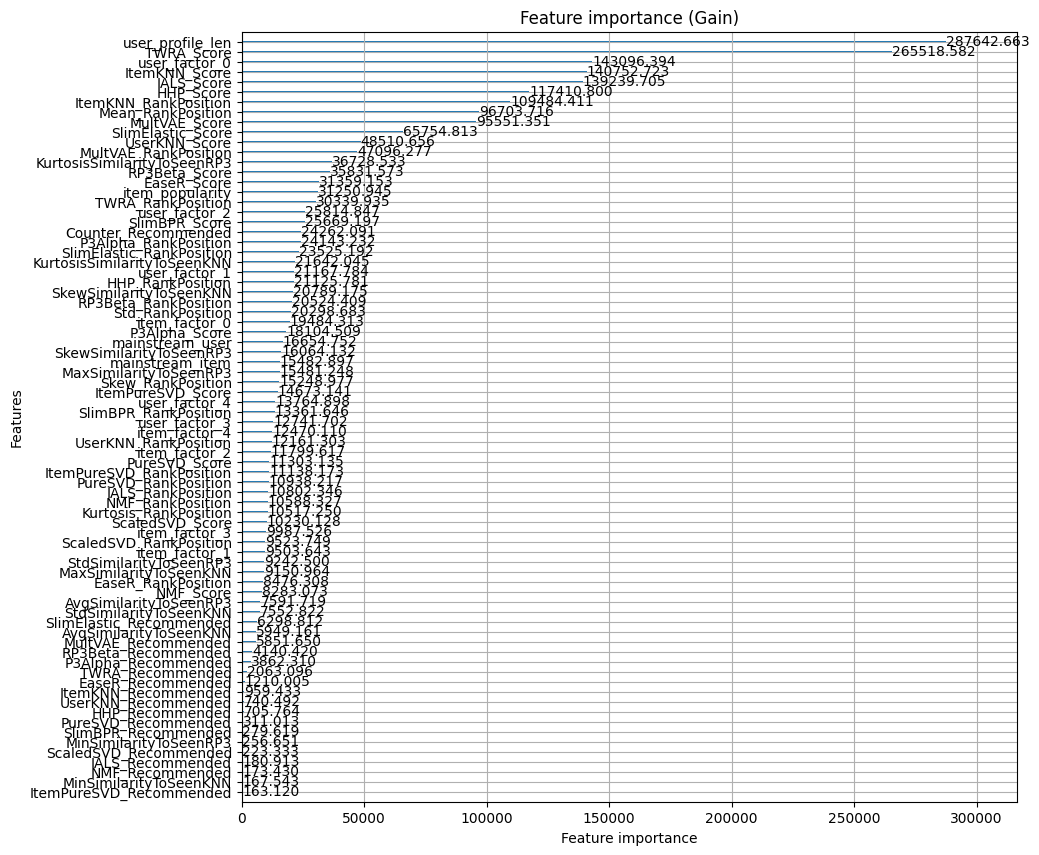

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_importance(LGBM_model, importance_type='gain', title='Feature importance (Gain)', ax=ax)

<Axes: title={'center': 'Feature importance (Split)'}, xlabel='Feature importance', ylabel='Features'>

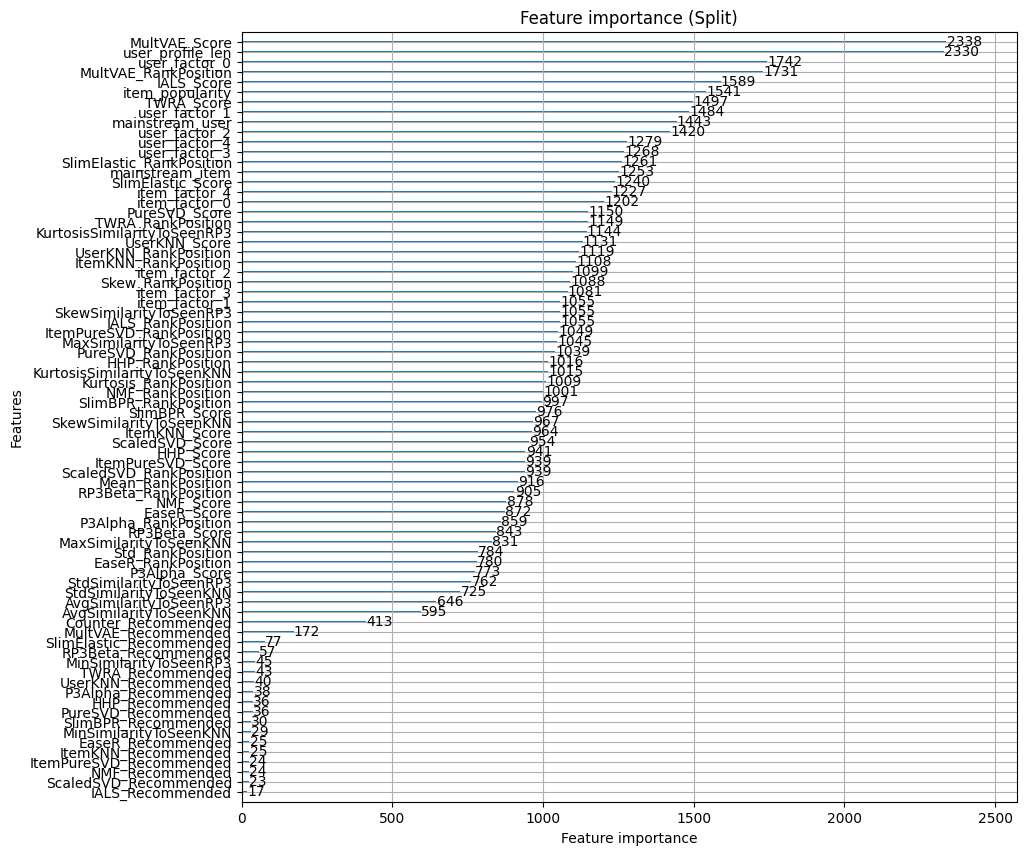

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_importance(LGBM_model, importance_type='split', title='Feature importance (Split)', ax=ax)

In [64]:
recommender_item = ItemKNNCFRecommender(URM_all)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_all)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_all)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_all)
recommender_p3a.fit(**params_p3alpha)

recommender_pure_svd = PureSVDRecommender(URM_all)
recommender_pure_svd.fit(num_factors=params_pure_svd['factors'])

recommender_pure_svd_item = PureSVDItemRecommender(URM_all)
recommender_pure_svd_item.fit(**params_pure_svd_item)

recommender_nmf = NMFRecommender(URM_all)
recommender_nmf.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'nmf_all.zip')

recommender_slim_bpr = SLIM_BPR_Python(URM_all)
recommender_slim_bpr.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_bpr_all.zip')

recommender_slim = SLIMElasticNetRecommender(URM_all)
recommender_slim.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_elastic_all.zip')

recommender_ease_r = EASE_R_Recommender(URM_all)
recommender_ease_r.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'ease_r_all.zip')

recommender_ials = IALSRecommender(URM_all)
recommender_ials.load_model('/kaggle/working/', 'ials_all.zip')

recommender_vae = MultVAERecommender(URM_all)
recommender_vae.load_model('/kaggle/working/', 'mult_vae_2_all')

recommender_hhp = HHPRecommender(URM_all)
recommender_hhp.fit(**params_hhp)

recommender_twra = TwoWayRankAggregationRecommender(URM_all)
recommender_twra.fit(**params_twra)

# recommender_als = ALSImplicitRecommender(URM_all)
# recommender_als.load_model('/kaggle/working/', 'als_all.npz')

########################## CANDIDATE GENERATORS ##########################

recommender_slim_recall = SLIMElasticNetRecommender(URM_all)
recommender_slim_recall.load_model('/kaggle/working/', 'slim_recall_all.zip')

recommender_rp3_recall = RP3betaRecommender(URM_all)
recommender_rp3_recall.fit(**params_rp3_recall)

recommender_item_recall = ItemKNNCFRecommender(URM_all)
recommender_item_recall.fit(**params_item_knn_recall)

ItemKNNCFRecommender: URM Detected 386 ( 3.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 125 ( 0.6%) items with no interactions.
Similarity column 22347 (100.0%), 4258.51 column/sec. Elapsed time 5.25 sec
UserKNNCFRecommender: URM Detected 386 ( 3.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 125 ( 0.6%) items with no interactions.
Similarity column 13024 (100.0%), 3977.01 column/sec. Elapsed time 3.27 sec
RP3betaRecommender: URM Detected 386 ( 3.0%) users with no interactions.
RP3betaRecommender: URM Detected 125 ( 0.6%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 2583.01 column/sec. Elapsed time 8.65 sec
P3alphaRecommender: URM Detected 386 ( 3.0%) users with no interactions.
P3alphaRecommender: URM Detected 125 ( 0.6%) items with no interactions.
P3alphaRecommender: Similarity column 22347 (100.0%), 2774.16 column/sec. Elapsed time 8.06 sec
PureSVDRecommender: URM Detected 386 ( 3.0%) users with no inter

In [65]:
recommender_object_dict = {
    'ItemKNN': recommender_item,
    'UserKNN': recommender_user,
    'P3Alpha': recommender_p3a,
    'RP3Beta': recommender_rp3,
    'NMF': recommender_nmf,
    'PureSVD': recommender_pure_svd,
    'ScaledSVD': recommender_scaled_svd,
    'ItemPureSVD': recommender_pure_svd_item,
    'SlimElastic': recommender_slim,
    'SlimBPR': recommender_slim_bpr,
    'EaseR': recommender_ease_r,
    'IALS': recommender_ials,
    'MultVAE': recommender_vae,
    'HHP': recommender_hhp,
    'TWRA': recommender_twra,
    # 'ALS': recommender_als
}

In [66]:
cutoff = 50
n_users, n_items = URM_all.shape

prediction_dataframe = pd.DataFrame(index=range(0, n_users), columns = ["ItemID"])
prediction_dataframe.index.name='UserID'

for user_id in tqdm.tqdm_notebook(range(n_users)):    
    recommendations_slim = recommender_slim_recall.recommend(user_id, cutoff = cutoff)
    recommendations_knn = recommender_item_recall.recommend(user_id, cutoff = cutoff)
    recommendations_rp3 = recommender_rp3_recall.recommend(user_id, cutoff = cutoff)
    recommendations = np.union1d(recommendations_slim, np.union1d(recommendations_knn, recommendations_rp3))
    prediction_dataframe.loc[user_id, "ItemID"] = recommendations
    
prediction_dataframe = prediction_dataframe.explode("ItemID")

for label, recommender in tqdm.auto.tqdm(recommender_object_dict.items()):
    scores = recommender._compute_item_score(np.arange(n_users))
    linf_scores = scores / (LA.norm(scores, np.inf, axis=1, keepdims=True) + 1e-6)
    
    for user_id in tqdm.auto.tqdm(range(n_users)):
        item_list = prediction_dataframe.loc[user_id, "ItemID"].values.tolist()
        linf_scores[user_id, :] = recommender._remove_seen_on_scores(user_id, linf_scores[user_id, :])
        prediction_dataframe.loc[user_id, f"{label}_Score"] = linf_scores[user_id, item_list]
        
        rank = np.argsort(linf_scores[user_id, :])[::-1]
        positions = np.zeros(n_items, dtype=int)
        positions[rank] = np.arange(n_items)
        prediction_dataframe.loc[user_id, f"{label}_RankPosition"] = positions[item_list]
        
        recommended = np.isin(item_list, rank[:10], assume_unique=True)
        prediction_dataframe.loc[user_id, f"{label}_Recommended"] = recommended.astype(int)
    
    del scores, linf_scores, rank, positions, recommended
    gc.collect()
    
item_item_S = recommender_item.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        prediction_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = 0
        prediction_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = 0
        prediction_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = 0
        prediction_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = 0
        prediction_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = 0
        prediction_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = 0
    else:
        similarities = item_item_S[prediction_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        prediction_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = similarities.mean(axis=1).flatten()
        prediction_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = similarities.max(axis=1).flatten()
        prediction_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = similarities.min(axis=1).flatten()
        prediction_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = similarities.std(axis=1).flatten()
        prediction_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = stats.skew(similarities, axis=1)
        prediction_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

item_item_S = recommender_rp3.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        prediction_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = 0
        prediction_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = 0
        prediction_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = 0
        prediction_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = 0
        prediction_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = 0
        prediction_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = 0
    else:
        similarities = item_item_S[prediction_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        prediction_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = similarities.mean(axis=1).flatten()
        prediction_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = similarities.max(axis=1).flatten()
        prediction_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = similarities.min(axis=1).flatten()
        prediction_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = similarities.std(axis=1).flatten()
        prediction_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = stats.skew(similarities, axis=1)
        prediction_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

prediction_dataframe = prediction_dataframe.reset_index()
prediction_dataframe = prediction_dataframe.rename(columns = {"index": "UserID"})

recommended_columns = [col for col in prediction_dataframe.columns if col.endswith('_Recommended')]
prediction_dataframe['Counter_Recommended'] = prediction_dataframe[recommended_columns].sum(axis=1).astype(int)

position_columns = [col for col in prediction_dataframe.columns if col.endswith('_RankPosition')]
prediction_dataframe['Mean_RankPosition'] = prediction_dataframe[position_columns].mean(axis=1)
prediction_dataframe['Std_RankPosition'] = prediction_dataframe[position_columns].std(axis=1)
prediction_dataframe['Skew_RankPosition'] = prediction_dataframe[position_columns].skew(axis=1)
prediction_dataframe['Kurtosis_RankPosition'] = prediction_dataframe[position_columns].kurtosis(axis=1)

item_popularity = np.ediff1d(sps.csc_matrix(URM_all).indptr)
item_popularity = item_popularity / np.max(item_popularity)
prediction_dataframe['item_popularity'] = item_popularity[prediction_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(URM_all).indptr)
user_popularity = user_popularity / np.max(user_popularity)
prediction_dataframe['user_profile_len'] = user_popularity[prediction_dataframe["UserID"].values.astype(int)]

mainstream_user = URM_all.dot(item_popularity) / np.where(user_popularity == 0, 1, user_popularity)
prediction_dataframe['mainstream_user'] = mainstream_user[prediction_dataframe["UserID"].values.astype(int)]

mainstream_item = URM_all.T.dot(user_popularity) / np.where(item_popularity == 0, 1, item_popularity)
prediction_dataframe['mainstream_item'] = mainstream_item[prediction_dataframe["ItemID"].values.astype(int)]

user_factors_df = pd.DataFrame(user_factors_final_train[:, :5], columns=[f'user_factor_{i}' for i in range(user_factors_final_train[:, :5].shape[1])])
item_factors_df = pd.DataFrame(item_factors_final_train[:, :5], columns=[f'item_factor_{i}' for i in range(item_factors_final_train[:, :5].shape[1])])

prediction_dataframe = prediction_dataframe.merge(item_factors_df, left_on='ItemID', right_index=True)
prediction_dataframe = prediction_dataframe.merge(user_factors_df, left_on='UserID', right_index=True)
prediction_dataframe = prediction_dataframe.sort_values(by='UserID')

prediction_dataframe["UserID"] = prediction_dataframe["UserID"].astype(int)
prediction_dataframe["ItemID"] = prediction_dataframe["ItemID"].astype(int)
prediction_dataframe

/tmp/ipykernel_18/3716254121.py:7: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

/tmp/ipykernel_18/3716254121.py:74: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.

/tmp/ipykernel_18/3716254121.py:75: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.



,UserID,ItemID,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,P3Alpha_RankPosition,...,item_factor_0,item_factor_1,item_factor_2,item_factor_3,item_factor_4,user_factor_0,user_factor_1,user_factor_2,user_factor_3,user_factor_4
0,0,0,0.000000,22150.0,0.0,0.049910,120.0,0.0,0.000000,22150.0,...,0.161283,0.057150,-0.179319,-0.017929,0.058489,0.005573,0.000276,0.007794,-0.010626,-0.001530
51,0,1067,0.000000,8330.0,0.0,0.055061,102.0,0.0,0.028730,174.0,...,0.006633,0.003640,0.012813,-0.006771,0.000972,0.005573,0.000276,0.007794,-0.010626,-0.001530
50,0,1056,0.148159,35.0,0.0,0.004526,4326.0,0.0,0.084663,23.0,...,0.002581,-0.001164,0.000103,-0.001671,0.001920,0.005573,0.000276,0.007794,-0.010626,-0.001530
49,0,976,0.166684,27.0,0.0,0.174678,9.0,1.0,0.044922,63.0,...,0.007626,-0.001412,0.009353,-0.007804,0.000635,0.005573,0.000276,0.007794,-0.010626,-0.001530
48,0,921,0.159207,31.0,0.0,0.106853,16.0,0.0,0.035512,102.0,...,0.008975,-0.001250,0.012296,-0.008343,0.003286,0.005573,0.000276,0.007794,-0.010626,-0.001530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1060085,13023,440,0.000000,7149.0,0.0,0.384692,27.0,0.0,0.000000,7177.0,...,0.017581,-0.029270,0.021202,0.014549,0.051794,0.009693,-0.007923,-0.000422,0.004503,0.023066
1060081,13023,346,0.087640,62.0,0.0,0.520535,7.0,1.0,0.076672,60.0,...,0.024040,-0.046680,0.024238,0.026045,0.079139,0.009693,-0.007923,-0.000422,0.004503,0.023066
1060080,13023,334,0.299805,21.0,0.0,0.400558,25.0,0.0,0.067050,72.0,...,0.023503,-0.038707,0.037088,0.024652,0.048741,0.009693,-0.007923,-0.000422,0.004503,0.023066
1060106,13023,3608,0.436101,10.0,0.0,0.359568,31.0,0.0,0.314715,18.0,...,0.003459,-0.010568,0.004390,0.002426,0.012327,0.009693,-0.007923,-0.000422,0.004503,0.023066


In [67]:
recommender = LightGBMRerankerRecommender(URM_all, LGBM_model, prediction_dataframe)

In [68]:
recommendations = recommender.recommend(user_ids_test['user_id'].unique() - 1, cutoff=10, return_scores=False)
recommendations = [' '.join([str(item + 1) for item in r]).strip() for r in recommendations]

submission_df = pd.DataFrame({'user_id': user_ids_test['user_id'].unique(), 'item_list': recommendations})
display(submission_df.head())

submission_df.to_csv('/kaggle/working/submission_lightgbm.csv', index=False)

,user_id,item_list
0,1,101 36 403 506 515 123 1546 977 694 637
1,2,1095 1522 47 12 196 359 8 3176 2 102
2,3,59 259 956 648 536 857 4252 584 414 239
3,4,249 28 50 7 146 5 139 314 2 3
4,5,1570 77 5138 131 471 170 1220 7033 270 1511
